### remember to change model saving path!!!

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss, TverskyLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class Ge_Benq_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size, training = True):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
        self.training = training
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        dataset = self.df["dataset"][idx]
        mask_type = self.df["mask_type"][idx]
        
        if dataset == "ge":
            from_dataset = 1
        elif dataset == "benq":
            from_dataset = 2

        if mask_type == "nodule":
            mask_type = 1
        elif mask_type == "gland":
            mask_type = 2

            
        if dataset == "benq":
            from_folder = "../gland_data"
        elif dataset == "ge":
            if mask_type == 1:
                if self.training:
                    from_folder = "../ge_data/nodule/train"
                else:
                    from_folder = "../ge_data/nodule/test"
            else:
                from_folder = "../ge_data/gland"
        
        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor, from_dataset, mask_type

In [5]:
image_size = 128
batch_size = 128
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.7
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
    #     image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    if(random.random() < p):
        # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        angle = 0.0
        max_dx = 0.05  # 水平平移比例
        max_dy = 0.3  # 垂直平移比例
        translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
        translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
        translate = (int(translate_x), int(translate_y))
        scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
        # scale = 1.0
        # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
        shear=[0.0, 0.0]
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return [None, None]
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = Ge_Benq_Dataset("../ge_benq_data/ge_benq_train_v2.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = Ge_Benq_Dataset("../ge_benq_data/ge_benq_test_v2.csv", transform = test_augmentation, image_size = image_size, training = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)

image, mask, from_dataset, mask_type = next(iter(test_dataloader))

In [6]:
from_dataset

tensor([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2,
        1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1,
        1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2])

In [7]:
mask_type

tensor([1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2,
        1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2,
        2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1,
        1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1,
        1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2])

In [8]:
ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1)]
ge_gland_mask = mask[(from_dataset == 1) & (mask_type == 2)]
benq_gland_mask = mask[(from_dataset == 2) & (mask_type == 2)]

In [9]:
(from_dataset == 1) & (mask_type == 1)

tensor([ True,  True, False, False,  True,  True, False,  True,  True,  True,
        False, False, False,  True,  True,  True, False,  True, False, False,
        False, False,  True, False,  True, False, False, False,  True, False,
        False,  True,  True, False,  True,  True,  True,  True,  True, False,
         True, False, False, False, False, False,  True, False, False,  True,
         True,  True,  True, False,  True,  True, False, False,  True,  True,
        False, False, False,  True, False,  True, False, False,  True, False,
         True,  True,  True, False, False,  True,  True,  True, False,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True, False,  True, False, False,  True,  True,  True,  True, False,
         True,  True, False,  True,  True,  True, False,  True, False, False,
        False,  True,  True,  True, False])

In [10]:
print(len(train_dataset), len(test_dataset))

777 229


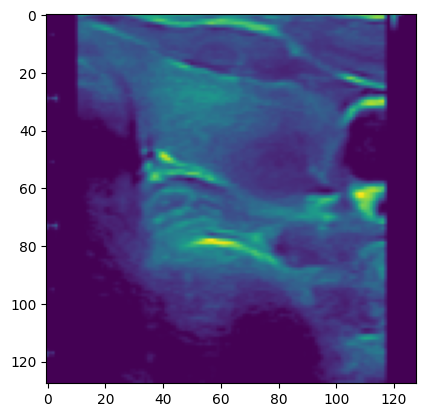

In [11]:
plt.imshow(image[18][0])

In [12]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0

    total_ge_nodule_IOU = 0
    total_ge_gland_IOU = 0
    total_benq_gland_IOU = 0
    
    total_ge_nodule_DICE = 0
    total_ge_gland_DICE = 0
    total_benq_gland_DICE = 0
    
    model.train()
    model.to(device)
    
    count = 0
    for image, mask, from_dataset, mask_type in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        # get output
        ge_nodule_output = nodule_output[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_output = gland_output[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_output = gland_output[(from_dataset == 2) & (mask_type == 2)]

        # get len
        ge_nodule_len = ge_nodule_output.shape[0]
        ge_gland_len = ge_gland_output.shape[0]
        benq_gland_len = benq_gland_output.shape[0]

        if ge_nodule_len == 0 or ge_gland_len == 0 or benq_gland_len == 0:
            continue

        nodule_ratio = ge_nodule_len / (ge_nodule_len + ge_gland_len + benq_gland_len)
        gland_ratio = (ge_gland_len + benq_gland_len) / (ge_nodule_len + ge_gland_len + benq_gland_len)
        
        ge_gland_ratio = ge_gland_len / (ge_gland_len + benq_gland_len)
        benq_gland_ratio = benq_gland_len / (ge_gland_len + benq_gland_len)
        
        # get mask
        ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_mask = mask[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_mask = mask[(from_dataset == 2) & (mask_type == 2)]
        
        #get loss
        ge_nodule_loss = loss_fn(ge_nodule_output, ge_nodule_mask)
        ge_gland_loss = loss_fn(ge_gland_output, ge_gland_mask)
        benq_gland_loss = loss_fn(benq_gland_output, benq_gland_mask)

        nodule_loss = ge_nodule_loss
        gland_loss = (ge_gland_loss * ge_gland_ratio + benq_gland_loss * benq_gland_ratio)
        loss = (nodule_loss * nodule_ratio + gland_loss * gland_ratio)
        
        # get IOU
        ge_nodule_IOU = IOU_score(ge_nodule_output, ge_nodule_mask)
        ge_gland_IOU = IOU_score(ge_gland_output, ge_gland_mask)
        benq_gland_IOU = IOU_score(benq_gland_output, benq_gland_mask)

        nodule_IOU = ge_nodule_IOU
        gland_IOU = (ge_gland_IOU * ge_gland_ratio + benq_gland_IOU * benq_gland_ratio)
        IOU = (nodule_IOU * nodule_ratio + gland_IOU * gland_ratio)

        # get DICE
        dice_loss = DiceLoss()
        
        ge_nodule_DICE = 1 - dice_loss(ge_nodule_output, ge_nodule_mask)
        ge_gland_DICE = 1 - dice_loss(ge_gland_output, ge_gland_mask)
        benq_gland_DICE = 1 - dice_loss(benq_gland_output, benq_gland_mask)

        nodule_DICE = ge_nodule_DICE
        gland_DICE = (ge_gland_DICE * ge_gland_ratio + benq_gland_DICE * benq_gland_ratio)
        DICE = (nodule_DICE * nodule_ratio + gland_DICE * gland_ratio)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()

        total_ge_nodule_IOU += ge_nodule_IOU
        total_ge_gland_IOU += ge_gland_IOU
        total_benq_gland_IOU += benq_gland_IOU

        total_ge_nodule_DICE += ge_nodule_DICE
        total_ge_gland_DICE += ge_gland_DICE
        total_benq_gland_DICE += benq_gland_DICE
        count+=1

    return total_loss/count, total_IOU/count, total_DICE/count, total_ge_nodule_IOU/count, total_ge_gland_IOU/count, total_benq_gland_IOU/count, total_ge_nodule_DICE/count, total_ge_gland_DICE/count, total_benq_gland_DICE/count


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0

    total_ge_nodule_IOU = 0
    total_ge_gland_IOU = 0
    total_benq_gland_IOU = 0
    
    total_ge_nodule_DICE = 0
    total_ge_gland_DICE = 0
    total_benq_gland_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, from_dataset, mask_type in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        # get output
        ge_nodule_output = nodule_output[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_output = gland_output[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_output = gland_output[(from_dataset == 2) & (mask_type == 2)]

        # get len
        ge_nodule_len = ge_nodule_output.shape[0]
        ge_gland_len = ge_gland_output.shape[0]
        benq_gland_len = benq_gland_output.shape[0]

        if ge_nodule_len == 0 or ge_gland_len == 0 or benq_gland_len == 0:
            continue
        nodule_ratio = ge_nodule_len / (ge_nodule_len + ge_gland_len + benq_gland_len)
        gland_ratio = (ge_gland_len + benq_gland_len) / (ge_nodule_len + ge_gland_len + benq_gland_len)
        
        ge_gland_ratio = ge_gland_len / (ge_gland_len + benq_gland_len)
        benq_gland_ratio = benq_gland_len / (ge_gland_len + benq_gland_len)
        
        # get mask
        ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_mask = mask[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_mask = mask[(from_dataset == 2) & (mask_type == 2)]
        
        #get loss
        ge_nodule_loss = loss_fn(ge_nodule_output, ge_nodule_mask)
        ge_gland_loss = loss_fn(ge_gland_output, ge_gland_mask)
        benq_gland_loss = loss_fn(benq_gland_output, benq_gland_mask)

        nodule_loss = ge_nodule_loss
        gland_loss = (ge_gland_loss * ge_gland_ratio + benq_gland_loss * benq_gland_ratio)
        loss = (nodule_loss * nodule_ratio + gland_loss * gland_ratio)
        
        # get IOU
        ge_nodule_IOU = IOU_score(ge_nodule_output, ge_nodule_mask)
        ge_gland_IOU = IOU_score(ge_gland_output, ge_gland_mask)
        benq_gland_IOU = IOU_score(benq_gland_output, benq_gland_mask)

        nodule_IOU = ge_nodule_IOU
        gland_IOU = (ge_gland_IOU * ge_gland_ratio + benq_gland_IOU * benq_gland_ratio)
        IOU = (nodule_IOU * nodule_ratio + gland_IOU * gland_ratio)

        # get DICE
        dice_loss = DiceLoss()
        
        ge_nodule_DICE = 1 - dice_loss(ge_nodule_output, ge_nodule_mask)
        ge_gland_DICE = 1 - dice_loss(ge_gland_output, ge_gland_mask)
        benq_gland_DICE = 1 - dice_loss(benq_gland_output, benq_gland_mask)

        nodule_DICE = ge_nodule_DICE
        gland_DICE = (ge_gland_DICE * ge_gland_ratio + benq_gland_DICE * benq_gland_ratio)
        DICE = (nodule_DICE * nodule_ratio + gland_DICE * gland_ratio)

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()

        total_ge_nodule_IOU += ge_nodule_IOU
        total_ge_gland_IOU += ge_gland_IOU
        total_benq_gland_IOU += benq_gland_IOU

        total_ge_nodule_DICE += ge_nodule_DICE
        total_ge_gland_DICE += ge_gland_DICE
        total_benq_gland_DICE += benq_gland_DICE
        count+=1

    return total_loss/count, total_IOU/count, total_DICE/count, total_ge_nodule_IOU/count, total_ge_gland_IOU/count, total_benq_gland_IOU/count, total_ge_nodule_DICE/count, total_ge_gland_DICE/count, total_benq_gland_DICE/count

    

In [13]:

inference_name = "models/Phase 1/Hybrid_crop_DDTI_standardization_aug_affine(0.5)_for_gland"

model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

<All keys matched successfully>

In [14]:
# freeze encoder
for param in model.backbone.parameters():
    param.requires_grad = False

In [15]:

epochs = 500
lr = 0.005
loss_fn = StructureLoss()
# loss_fn = TverskyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [16]:

project = "thyroid_ge_benq_finetune"
name = "hybrid_model_ge(nodule_gland)_benq(crop_gland)_baseline(1)_freeze_encoder_wo_zeromask_aug_space"
# name = "test"

wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [17]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.005, epochs : 500, batch size : 128


In [18]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train, ge_nodule_IOU_train, ge_gland_IOU_train, benq_gland_IOU_train, ge_nodule_DICE_train, ge_gland_DICE_train, benq_gland_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val, ge_nodule_IOU_val, ge_gland_IOU_val, benq_gland_IOU_val, ge_nodule_DICE_val, ge_gland_DICE_val, benq_gland_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/finetune/ge_benq/{name}/"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/finetune/ge_benq/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        "train_ge_nodule_IOU" : ge_nodule_IOU_train,
        "train_ge_nodule_DICE" : ge_nodule_DICE_train,
        "train_ge_gland_IOU" : ge_gland_IOU_train,
        "train_ge_gland_DICE" : ge_gland_DICE_train,
        "train_benq_gland_IOU" : benq_gland_IOU_train,
        "train_benq_gland_DICE" : benq_gland_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        "val_ge_nodule_IOU" : ge_nodule_IOU_val,
        "val_ge_nodule_DICE" : ge_nodule_DICE_val,
        "val_ge_gland_IOU" : ge_gland_IOU_val,
        "val_ge_gland_DICE" : ge_gland_DICE_val,
        "val_benq_gland_IOU" : benq_gland_IOU_val,
        "val_benq_gland_DICE" : benq_gland_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
torch.save(checkpoint, f"models/finetune/ge_benq/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


train loss : 0.7724278171857198, train IOU : 0.5006823788086573, train DICE : 0.645575205485026


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.527380183339119, val IOU : 0.6610391736030579, val DICE : 0.761641263961792
epoch : 1


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.6017983655134836, train IOU : 0.559646745522817, train DICE : 0.6856493552525839


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.5311913043260574, val IOU : 0.6454272270202637, val DICE : 0.7490658164024353
epoch : 2


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.5812642744609288, train IOU : 0.5735551629747663, train DICE : 0.701907753944397


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.49283263087272644, val IOU : 0.6664207577705383, val DICE : 0.7638454437255859
epoch : 3


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.5158985257148743, train IOU : 0.599562406539917, train DICE : 0.7059437462261745


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4992983043193817, val IOU : 0.6483908295631409, val DICE : 0.7471320927143097
epoch : 4


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.5100507934888204, train IOU : 0.6045557061831156, train DICE : 0.7209469477335612


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.48440125584602356, val IOU : 0.6567449569702148, val DICE : 0.7542738616466522
epoch : 5


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.47298499941825867, train IOU : 0.6165239555495126, train DICE : 0.7301307490893773


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.46722574532032013, val IOU : 0.6692460775375366, val DICE : 0.7651127576828003
epoch : 6


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.48125750323136646, train IOU : 0.6222038865089417, train DICE : 0.7340331375598907


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4723323583602905, val IOU : 0.6656759977340698, val DICE : 0.7601858079433441
epoch : 7


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


train loss : 0.4619095027446747, train IOU : 0.6264088409287589, train DICE : 0.7464672412191119


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.4638485014438629, val IOU : 0.6693366765975952, val DICE : 0.7669111490249634
epoch : 8


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.46666309237480164, train IOU : 0.6351783076922098, train DICE : 0.7527892092863718


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.456536129117012, val IOU : 0.6794342398643494, val DICE : 0.7724847495555878
epoch : 9


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.4531709800163905, train IOU : 0.6463777323563894, train DICE : 0.755329837401708


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.46111033856868744, val IOU : 0.6641587018966675, val DICE : 0.763854444026947
epoch : 10


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.4402769257624944, train IOU : 0.6402988731861115, train DICE : 0.7608662545681


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.45534318685531616, val IOU : 0.6795316934585571, val DICE : 0.7728343605995178
epoch : 11


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.4611320247252782, train IOU : 0.642256885766983, train DICE : 0.7492454051971436


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.45633262395858765, val IOU : 0.6704005300998688, val DICE : 0.7662934362888336
epoch : 12


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.4405019283294678, train IOU : 0.6482269253049578, train DICE : 0.7618813514709473


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4610293358564377, val IOU : 0.6760111451148987, val DICE : 0.7670896053314209
epoch : 13


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.4297956015382494, train IOU : 0.6608057958739144, train DICE : 0.7598864180701119


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.45390239357948303, val IOU : 0.6784067749977112, val DICE : 0.7706202268600464
epoch : 14


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.4340408096710841, train IOU : 0.6562974552313486, train DICE : 0.7661798099676768


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.43925391137599945, val IOU : 0.6872342824935913, val DICE : 0.7815417051315308
epoch : 15


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.41781316697597504, train IOU : 0.668266087770462, train DICE : 0.7797061403592428


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.441241130232811, val IOU : 0.6866908073425293, val DICE : 0.7791500687599182
epoch : 16


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.4196411818265915, train IOU : 0.6673971811930338, train DICE : 0.7705353498458862


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.44243335723876953, val IOU : 0.6829303205013275, val DICE : 0.776978611946106
epoch : 17


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.4061415536063058, train IOU : 0.6678497535841805, train DICE : 0.7624019043786185


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4469570815563202, val IOU : 0.690036952495575, val DICE : 0.7811059057712555
epoch : 18


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.4117530882358551, train IOU : 0.6737655202547709, train DICE : 0.7824518879254659


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44453687965869904, val IOU : 0.6792333126068115, val DICE : 0.7786529362201691
epoch : 19


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.4142232487599055, train IOU : 0.6650311847527822, train DICE : 0.7766298453013102


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4545166790485382, val IOU : 0.6806317865848541, val DICE : 0.7746333181858063
epoch : 20


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.4260933143751962, train IOU : 0.661024911063058, train DICE : 0.7738034725189209


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4446677267551422, val IOU : 0.6818649768829346, val DICE : 0.775136411190033
epoch : 21


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.41436160036495756, train IOU : 0.6629508137702942, train DICE : 0.7686121463775635


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.45051588118076324, val IOU : 0.6814925670623779, val DICE : 0.7746806740760803
epoch : 22


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


train loss : 0.40306090315183, train IOU : 0.6799789766470591, train DICE : 0.7795792818069458


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.45303061604499817, val IOU : 0.6772832274436951, val DICE : 0.7755141854286194
epoch : 23


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.39229168210710796, train IOU : 0.6881621139390128, train DICE : 0.787588085447039


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4546037018299103, val IOU : 0.6828686594963074, val DICE : 0.7783493995666504
epoch : 24


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.4081362783908844, train IOU : 0.6747966508070627, train DICE : 0.7850625813007355


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4681035578250885, val IOU : 0.6623771786689758, val DICE : 0.7639788091182709
epoch : 25


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.3967861632506053, train IOU : 0.6887027422587076, train DICE : 0.784522294998169


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4353600889444351, val IOU : 0.6896770596504211, val DICE : 0.7885510921478271
epoch : 26


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.38927928109963733, train IOU : 0.6853634019692739, train DICE : 0.790847510099411


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4620554447174072, val IOU : 0.6735790967941284, val DICE : 0.770258367061615
epoch : 27


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.3787204474210739, train IOU : 0.69318887591362, train DICE : 0.7949528296788534


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.46821849048137665, val IOU : 0.6686060726642609, val DICE : 0.7641569375991821
epoch : 28


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.3697254402296884, train IOU : 0.7101995774677822, train DICE : 0.8067976491791862


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.43696489930152893, val IOU : 0.6860977411270142, val DICE : 0.7852580547332764
epoch : 29


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.38850489755471546, train IOU : 0.6820576985677084, train DICE : 0.7965555389722189


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4437815397977829, val IOU : 0.6877152025699615, val DICE : 0.7852081060409546
epoch : 30


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.37716239265033175, train IOU : 0.7025448169027056, train DICE : 0.7993432538849967


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.4489224702119827, val IOU : 0.679225891828537, val DICE : 0.7782859206199646
epoch : 31


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.38425080974896747, train IOU : 0.6958547433217367, train DICE : 0.7989495595296224


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.45287615060806274, val IOU : 0.6855968832969666, val DICE : 0.7813734412193298
epoch : 32


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.386799088546208, train IOU : 0.6941353763852801, train DICE : 0.7950348258018494


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4476311206817627, val IOU : 0.6883791089057922, val DICE : 0.779485672712326
epoch : 33


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.37180955211321515, train IOU : 0.7059965332349142, train DICE : 0.8058863878250122


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4363943189382553, val IOU : 0.6910356879234314, val DICE : 0.78722083568573
epoch : 34


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.3698404182990392, train IOU : 0.7050690452257792, train DICE : 0.8023013571898142


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4743107557296753, val IOU : 0.6663684248924255, val DICE : 0.768224835395813
epoch : 35


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.3764823206833431, train IOU : 0.7105558855193002, train DICE : 0.8073817065783909


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.43077124655246735, val IOU : 0.6990111470222473, val DICE : 0.7952397763729095
epoch : 36


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.3561409328665052, train IOU : 0.7251285314559937, train DICE : 0.814131328037807


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.43354976177215576, val IOU : 0.6904184818267822, val DICE : 0.7869353890419006
epoch : 37


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.37632650562695097, train IOU : 0.7011697718075344, train DICE : 0.8060674837657383


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.42947448790073395, val IOU : 0.6942498087882996, val DICE : 0.7920184433460236
epoch : 38


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


train loss : 0.371878411088671, train IOU : 0.7068665112767901, train DICE : 0.7939488972936358


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.44941282272338867, val IOU : 0.6809922754764557, val DICE : 0.7814792394638062
epoch : 39


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.37489273292677744, train IOU : 0.7037239415305001, train DICE : 0.8005836946623666


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.45017023384571075, val IOU : 0.6850517988204956, val DICE : 0.7822745442390442
epoch : 40


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.36641613500458853, train IOU : 0.6905137641089303, train DICE : 0.791750967502594


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4799674451351166, val IOU : 0.6691546440124512, val DICE : 0.7647689580917358
epoch : 41


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.3831229458252589, train IOU : 0.6987425982952118, train DICE : 0.7961218257745107


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4478098750114441, val IOU : 0.6779187917709351, val DICE : 0.7815417349338531
epoch : 42


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.3691430191198985, train IOU : 0.6960728069146475, train DICE : 0.8070225715637207


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.46163003146648407, val IOU : 0.680679976940155, val DICE : 0.776719868183136
epoch : 43


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.35567693909009296, train IOU : 0.7135813434918722, train DICE : 0.8127180437246958


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4312537759542465, val IOU : 0.6966760158538818, val DICE : 0.7923908233642578
epoch : 44


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.3518940309683482, train IOU : 0.7217687765757242, train DICE : 0.8134961823622385


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4438319057226181, val IOU : 0.6900327801704407, val DICE : 0.781204104423523
epoch : 45


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.34889476994673413, train IOU : 0.7248323559761047, train DICE : 0.8138457338015238


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4271274656057358, val IOU : 0.6966694891452789, val DICE : 0.7924555242061615
epoch : 46


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.35153525074323017, train IOU : 0.7194271286328634, train DICE : 0.8148911595344543


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.44902944564819336, val IOU : 0.6933578848838806, val DICE : 0.7855441570281982
epoch : 47


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.3530817925930023, train IOU : 0.7157087425390879, train DICE : 0.816698839267095


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.43186137080192566, val IOU : 0.6932682693004608, val DICE : 0.7913230657577515
epoch : 48


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.3716094493865967, train IOU : 0.717637687921524, train DICE : 0.8174583911895752


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.44435954093933105, val IOU : 0.6933532357215881, val DICE : 0.7879233956336975
epoch : 49


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.3481560895840327, train IOU : 0.7190231084823608, train DICE : 0.8154566586017609


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44709503650665283, val IOU : 0.6876741349697113, val DICE : 0.7851440906524658
epoch : 50


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.3555809089115688, train IOU : 0.7154932788440159, train DICE : 0.8137386866978237


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44801703095436096, val IOU : 0.6823604702949524, val DICE : 0.7811264097690582
epoch : 51


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.34502598146597546, train IOU : 0.7262310783068339, train DICE : 0.8180819749832153


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.44751033186912537, val IOU : 0.6878260970115662, val DICE : 0.7856356501579285
epoch : 52


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.3265320261319478, train IOU : 0.7412241399288177, train DICE : 0.8246364494164785


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4574781805276871, val IOU : 0.6866529285907745, val DICE : 0.7809856534004211
epoch : 53


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.34015211888722013, train IOU : 0.7382551601954869, train DICE : 0.8185797248567853


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4318760633468628, val IOU : 0.6922219693660736, val DICE : 0.7935405075550079
epoch : 54


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.36564359068870544, train IOU : 0.7154053364481244, train DICE : 0.8041061418397086


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4406765401363373, val IOU : 0.6899654269218445, val DICE : 0.7900300920009613
epoch : 55


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.33640314141909283, train IOU : 0.7281086246172587, train DICE : 0.8219159543514252


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.47762802243232727, val IOU : 0.6633204519748688, val DICE : 0.7694865763187408
epoch : 56


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.33033848660332815, train IOU : 0.746503974710192, train DICE : 0.8347503117152623


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.45002713799476624, val IOU : 0.6840416789054871, val DICE : 0.7845440208911896
epoch : 57


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.3357073863347371, train IOU : 0.7316483855247498, train DICE : 0.8238477806250254


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4518464058637619, val IOU : 0.6846511960029602, val DICE : 0.7808621525764465
epoch : 58


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.35128084676606314, train IOU : 0.7201149974550519, train DICE : 0.8135280183383397


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.45493656396865845, val IOU : 0.6873717904090881, val DICE : 0.780037522315979
epoch : 59


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.33996215036937166, train IOU : 0.7174762231963021, train DICE : 0.8139936072485787


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.456907719373703, val IOU : 0.6905021965503693, val DICE : 0.7849363088607788
epoch : 60


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.3488552612917764, train IOU : 0.7187531164714268, train DICE : 0.8153444954327175


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.44946610927581787, val IOU : 0.6789727807044983, val DICE : 0.7832525372505188
epoch : 61


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.33089495201905567, train IOU : 0.7427806158860525, train DICE : 0.8266693651676178


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4303072839975357, val IOU : 0.6979955434799194, val DICE : 0.7960264086723328
epoch : 62


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.33147528767585754, train IOU : 0.7263410687446594, train DICE : 0.8276687959829966


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4605325907468796, val IOU : 0.6843368411064148, val DICE : 0.781129390001297
epoch : 63


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.329422937972205, train IOU : 0.7458874072347369, train DICE : 0.8355481284005302


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.43434497714042664, val IOU : 0.6931385397911072, val DICE : 0.7934514284133911
epoch : 64


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.34252164761225384, train IOU : 0.7246303856372833, train DICE : 0.8192003071308136


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.47025978565216064, val IOU : 0.6740230917930603, val DICE : 0.7735796868801117
epoch : 65


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


train loss : 0.32886648178100586, train IOU : 0.732713520526886, train DICE : 0.8278006116549174


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4488958865404129, val IOU : 0.6839212477207184, val DICE : 0.7832758724689484
epoch : 66


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.3199969232082367, train IOU : 0.7528983851273855, train DICE : 0.8316349387168884


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.4324958175420761, val IOU : 0.6970869898796082, val DICE : 0.7936669588088989
epoch : 67


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.32707078754901886, train IOU : 0.7376868824164072, train DICE : 0.8253359397252401


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.43766915798187256, val IOU : 0.6936405301094055, val DICE : 0.7908545434474945
epoch : 68


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.3204989433288574, train IOU : 0.740939994653066, train DICE : 0.8309802909692129


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4386683851480484, val IOU : 0.6924360394477844, val DICE : 0.79238361120224
epoch : 69


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.3434934403215136, train IOU : 0.7337539281163897, train DICE : 0.8159277609416417


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.45350365340709686, val IOU : 0.6803163290023804, val DICE : 0.7816548347473145
epoch : 70


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.3302492243903024, train IOU : 0.7400629435266767, train DICE : 0.8258276922362191


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4401753842830658, val IOU : 0.6919452548027039, val DICE : 0.7904982566833496
epoch : 71


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.3172090947628021, train IOU : 0.7467220028241476, train DICE : 0.8391840755939484


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4297470599412918, val IOU : 0.6994287371635437, val DICE : 0.7982194125652313
epoch : 72


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.3163670854909079, train IOU : 0.7499349117279053, train DICE : 0.8413985456739154


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.443504273891449, val IOU : 0.6879018247127533, val DICE : 0.7896583080291748
epoch : 73


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


train loss : 0.31549827257792157, train IOU : 0.749522477388382, train DICE : 0.8332874079545339


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.4408036768436432, val IOU : 0.6974672973155975, val DICE : 0.7947883903980255
epoch : 74


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.31605877975622815, train IOU : 0.7519103387991587, train DICE : 0.8360495567321777


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4358547329902649, val IOU : 0.6921896040439606, val DICE : 0.7916390299797058
epoch : 75


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.31741075430597576, train IOU : 0.7443639636039734, train DICE : 0.8296260748590741


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.458706334233284, val IOU : 0.6820291578769684, val DICE : 0.7831589877605438
epoch : 76


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.30722696014813017, train IOU : 0.7504913977214268, train DICE : 0.8408803684370858


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.45343226194381714, val IOU : 0.6895582973957062, val DICE : 0.788952112197876
epoch : 77


100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


train loss : 0.31499231713158743, train IOU : 0.7525606836591449, train DICE : 0.8354083129337856


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.4451579451560974, val IOU : 0.6919994354248047, val DICE : 0.7896510362625122
epoch : 78


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.3160778880119324, train IOU : 0.7456656098365784, train DICE : 0.8312072654565176


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4274507164955139, val IOU : 0.7022857069969177, val DICE : 0.7990836799144745
epoch : 79


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.30582024653752643, train IOU : 0.7502198417981466, train DICE : 0.8422336677710215


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.44875484704971313, val IOU : 0.6942600011825562, val DICE : 0.7901714146137238
epoch : 80


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.3113354742527008, train IOU : 0.7515613238016764, train DICE : 0.8411565323670706


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.438910648226738, val IOU : 0.6908089816570282, val DICE : 0.7910278737545013
epoch : 81


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


train loss : 0.3078337780066899, train IOU : 0.7561152832848685, train DICE : 0.8442177261625018


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4329787939786911, val IOU : 0.6947906911373138, val DICE : 0.796489417552948
epoch : 82


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.31065950223377775, train IOU : 0.7554199525288173, train DICE : 0.8426617383956909


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4359000325202942, val IOU : 0.6932999491691589, val DICE : 0.7959678471088409
epoch : 83


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.33729210992654163, train IOU : 0.7223997513453165, train DICE : 0.8192991415659586


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.47171416878700256, val IOU : 0.6791039705276489, val DICE : 0.7757847607135773
epoch : 84


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.3278845300277074, train IOU : 0.7391992012659708, train DICE : 0.8276692628860474


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.44249218702316284, val IOU : 0.6903349757194519, val DICE : 0.791819304227829
epoch : 85


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.30938901503880817, train IOU : 0.7565937936306, train DICE : 0.8376998007297516


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.43614114820957184, val IOU : 0.6990922093391418, val DICE : 0.7956604063510895
epoch : 86


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.311195303996404, train IOU : 0.7401115794976553, train DICE : 0.8334415853023529


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4602676182985306, val IOU : 0.6861932873725891, val DICE : 0.781746506690979
epoch : 87


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.31763572494188946, train IOU : 0.7473044693470001, train DICE : 0.8328315118948618


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4367195814847946, val IOU : 0.6926021873950958, val DICE : 0.7931898832321167
epoch : 88


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.30724134544531506, train IOU : 0.7560592095057169, train DICE : 0.8423160413901011


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4586607664823532, val IOU : 0.688164472579956, val DICE : 0.7847597301006317
epoch : 89


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.29787537455558777, train IOU : 0.7561413730893817, train DICE : 0.850651468549456


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44121579825878143, val IOU : 0.692921906709671, val DICE : 0.7914780378341675
epoch : 90


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.306538184483846, train IOU : 0.7581544319788615, train DICE : 0.8403277198473612


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4354938864707947, val IOU : 0.6968837976455688, val DICE : 0.7965647876262665
epoch : 91


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.2957947254180908, train IOU : 0.7607647081216177, train DICE : 0.8463015854358673


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4522501528263092, val IOU : 0.6910200119018555, val DICE : 0.7883473038673401
epoch : 92


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.28979556049619404, train IOU : 0.768277611051287, train DICE : 0.8477132575852531


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.44422368705272675, val IOU : 0.6978200078010559, val DICE : 0.7938823401927948
epoch : 93


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.30749864379564923, train IOU : 0.7595410346984863, train DICE : 0.8468132515748342


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4417895972728729, val IOU : 0.6837309300899506, val DICE : 0.7898163795471191
epoch : 94


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.30249960720539093, train IOU : 0.7531732718149821, train DICE : 0.8430544634660085


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44541528820991516, val IOU : 0.6954140067100525, val DICE : 0.7939662039279938
epoch : 95


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.2984605261257717, train IOU : 0.7492184553827558, train DICE : 0.842514021056039


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.46530763804912567, val IOU : 0.6804520487785339, val DICE : 0.7763969302177429
epoch : 96


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.3060958633820216, train IOU : 0.7529232899347941, train DICE : 0.8438728253046671


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.31045114568301607, train IOU : 0.7664883817945208, train DICE : 0.8453714506966727


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.46828918159008026, val IOU : 0.6727108061313629, val DICE : 0.7778170108795166
epoch : 106


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.31407153109709424, train IOU : 0.7371088763078054, train DICE : 0.8351281483968099


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4625580757856369, val IOU : 0.6881166398525238, val DICE : 0.7891992330551147
epoch : 107


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.3141737239701407, train IOU : 0.752534806728363, train DICE : 0.8389080251966204


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4473564773797989, val IOU : 0.6925384700298309, val DICE : 0.7931101322174072
epoch : 108


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.31427862246831256, train IOU : 0.7499949038028717, train DICE : 0.8361110786596934


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4222223609685898, val IOU : 0.7102895975112915, val DICE : 0.8097842633724213
epoch : 109


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.2954798142115275, train IOU : 0.7619972030321757, train DICE : 0.8525155981381735


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.46892452239990234, val IOU : 0.6756013631820679, val DICE : 0.777619481086731
epoch : 110


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.311584289584841, train IOU : 0.7508897951671055, train DICE : 0.8447957294327872


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.42691144347190857, val IOU : 0.7022779285907745, val DICE : 0.8034029304981232
epoch : 111


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.3014289694172995, train IOU : 0.7605788452284676, train DICE : 0.8390008040836879


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4468603879213333, val IOU : 0.6862869560718536, val DICE : 0.7869862914085388
epoch : 112


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.3031866294997079, train IOU : 0.7572864464351109, train DICE : 0.8376888292176383


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4400688707828522, val IOU : 0.6923457086086273, val DICE : 0.7948945164680481
epoch : 113


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.28661545117696124, train IOU : 0.7702857255935669, train DICE : 0.8533967932065328


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.45378997921943665, val IOU : 0.6864326298236847, val DICE : 0.7899234592914581
epoch : 114


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.301390677690506, train IOU : 0.7540710667769114, train DICE : 0.846195379892985


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4355047792196274, val IOU : 0.702138751745224, val DICE : 0.7999562919139862
epoch : 115


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.2811173001925151, train IOU : 0.7817144989967346, train DICE : 0.8534411489963531


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.42589911818504333, val IOU : 0.701578676700592, val DICE : 0.8029247522354126
epoch : 116


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


train loss : 0.2897063536303384, train IOU : 0.7694279636655535, train DICE : 0.8519380688667297


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.42533986270427704, val IOU : 0.7069526016712189, val DICE : 0.806340903043747
epoch : 117


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.3025680482387543, train IOU : 0.7651321717670986, train DICE : 0.8486748593194144


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.42370080947875977, val IOU : 0.7059303224086761, val DICE : 0.8059773445129395
epoch : 118


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.30828344396182467, train IOU : 0.766249247959682, train DICE : 0.8494750516755241


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4241110235452652, val IOU : 0.706186830997467, val DICE : 0.8059415817260742
epoch : 119


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.29835377633571625, train IOU : 0.756589541832606, train DICE : 0.8428276479244232


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4480491280555725, val IOU : 0.6960591077804565, val DICE : 0.7935487031936646
epoch : 120


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.30674119080816, train IOU : 0.7536190663065229, train DICE : 0.8458072202546256


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4345289170742035, val IOU : 0.6957721710205078, val DICE : 0.7967859506607056
epoch : 121


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.2937248796224594, train IOU : 0.766055186589559, train DICE : 0.8492854038874308


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.45027823746204376, val IOU : 0.694332480430603, val DICE : 0.7949863970279694
epoch : 122


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.29082157214482623, train IOU : 0.7685250341892242, train DICE : 0.850414494673411


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4276977628469467, val IOU : 0.7050674855709076, val DICE : 0.8044028878211975
epoch : 123


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2882293292454311, train IOU : 0.7752561313765389, train DICE : 0.8530348794800895


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4356091618537903, val IOU : 0.6994078755378723, val DICE : 0.7963840961456299
epoch : 124


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


train loss : 0.286979744831721, train IOU : 0.771916796763738, train DICE : 0.8514068325360616


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.432643324136734, val IOU : 0.7017218470573425, val DICE : 0.8000777959823608
epoch : 125


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2960192007677896, train IOU : 0.766357251576015, train DICE : 0.8537104385239738


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.44388264417648315, val IOU : 0.6929706037044525, val DICE : 0.7957335114479065
epoch : 126


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.289616400996844, train IOU : 0.7640378574530283, train DICE : 0.8540004392464956


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4527202397584915, val IOU : 0.6872178614139557, val DICE : 0.7912715077400208
epoch : 127


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.3062362160001482, train IOU : 0.7496615988867623, train DICE : 0.8421583686556134


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4653173089027405, val IOU : 0.6839739680290222, val DICE : 0.7842763662338257
epoch : 128


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


train loss : 0.30260851979255676, train IOU : 0.7638227542241415, train DICE : 0.8485228220621744


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.46483510732650757, val IOU : 0.6707867980003357, val DICE : 0.7774879336357117
epoch : 129


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.29699653883775073, train IOU : 0.7603660821914673, train DICE : 0.8475515246391296


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4616641402244568, val IOU : 0.6903914213180542, val DICE : 0.7906452119350433
epoch : 130


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.283215656876564, train IOU : 0.7762976984182993, train DICE : 0.8584461708863577


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.43253032863140106, val IOU : 0.7064060866832733, val DICE : 0.8060011565685272
epoch : 131


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.2881309390068054, train IOU : 0.7701167166233063, train DICE : 0.8554435074329376


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.4614282548427582, val IOU : 0.6812004745006561, val DICE : 0.7809991538524628
epoch : 132


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.28654339412848157, train IOU : 0.7679119606812795, train DICE : 0.8527750273545583


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4377947300672531, val IOU : 0.7056765556335449, val DICE : 0.8028635680675507
epoch : 133


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.295504887898763, train IOU : 0.7634081244468689, train DICE : 0.8489087720712026


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.4318757951259613, val IOU : 0.698621928691864, val DICE : 0.799474835395813
epoch : 134


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.28405677775541943, train IOU : 0.7741068700949351, train DICE : 0.8543002903461456


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4212993085384369, val IOU : 0.7101151943206787, val DICE : 0.8089996874332428
epoch : 135


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.2779642691214879, train IOU : 0.771962175766627, train DICE : 0.8529025216897329


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4526929259300232, val IOU : 0.6970198154449463, val DICE : 0.7951571047306061
epoch : 136


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.284908264875412, train IOU : 0.7743366460005442, train DICE : 0.8598261872927347


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.4213981181383133, val IOU : 0.7058233022689819, val DICE : 0.8069367110729218
epoch : 137


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.28347423672676086, train IOU : 0.7716786776270185, train DICE : 0.8477709548813956


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.419142410159111, val IOU : 0.7129004001617432, val DICE : 0.8108622133731842
epoch : 138


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2776256302992503, train IOU : 0.7780324220657349, train DICE : 0.8598716060320536


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.43115898966789246, val IOU : 0.6973838806152344, val DICE : 0.8000422716140747
epoch : 139


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.2932478040456772, train IOU : 0.7579848070939382, train DICE : 0.8513204157352448


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4597797095775604, val IOU : 0.6909550130367279, val DICE : 0.7890353798866272
epoch : 140


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.2820333292086919, train IOU : 0.7720572650432587, train DICE : 0.8603010475635529


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4295828640460968, val IOU : 0.7053230702877045, val DICE : 0.8048721849918365
epoch : 141


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2778968811035156, train IOU : 0.7869451727185931, train DICE : 0.8635932888303485


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4419039189815521, val IOU : 0.68637415766716, val DICE : 0.7922749519348145
epoch : 142


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.30128132019724163, train IOU : 0.7431661060878209, train DICE : 0.8322534220559257


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4342445731163025, val IOU : 0.7076743245124817, val DICE : 0.8065721690654755
epoch : 143


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.29431552972112385, train IOU : 0.7599420292036874, train DICE : 0.8542127438953945


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4440908133983612, val IOU : 0.6877222061157227, val DICE : 0.7931368947029114
epoch : 144


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.27128757749285015, train IOU : 0.785718560218811, train DICE : 0.8631242854254586


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.4373110979795456, val IOU : 0.699331521987915, val DICE : 0.8003253936767578
epoch : 145


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.28628691534201306, train IOU : 0.776659240325292, train DICE : 0.8540035883585612


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.45309118926525116, val IOU : 0.6858992874622345, val DICE : 0.7862552404403687
epoch : 146


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.3090508495058332, train IOU : 0.7514758450644357, train DICE : 0.842587913785662


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.420823410153389, val IOU : 0.7103954255580902, val DICE : 0.8109660744667053
epoch : 147


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2953822712103526, train IOU : 0.7593637903531393, train DICE : 0.8489831288655599


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.4343115985393524, val IOU : 0.6937831342220306, val DICE : 0.7975362539291382
epoch : 148


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.28562622765700024, train IOU : 0.771242747704188, train DICE : 0.8546744187672933


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.45540912449359894, val IOU : 0.682878851890564, val DICE : 0.7851360738277435
epoch : 149


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.2785361309846242, train IOU : 0.7762610713640848, train DICE : 0.8567303121089935


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44769422709941864, val IOU : 0.6961253881454468, val DICE : 0.7956733405590057
epoch : 150


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.28328845898310345, train IOU : 0.775203675031662, train DICE : 0.8600786129633585


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4305132329463959, val IOU : 0.7025513350963593, val DICE : 0.8023878335952759
epoch : 151


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.27521057923634845, train IOU : 0.7805340786774954, train DICE : 0.8636807501316071


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.43304768204689026, val IOU : 0.7063675224781036, val DICE : 0.8028304576873779
epoch : 152


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.28191961348056793, train IOU : 0.779135932524999, train DICE : 0.8558292885621389


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4214898645877838, val IOU : 0.7094038128852844, val DICE : 0.8082143068313599
epoch : 153


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.27481743196646374, train IOU : 0.7816677689552307, train DICE : 0.8648741642634074


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4305931627750397, val IOU : 0.703171581029892, val DICE : 0.8031878471374512
epoch : 154


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.27836276590824127, train IOU : 0.7725034554799398, train DICE : 0.8571580350399017


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4460008442401886, val IOU : 0.6946908533573151, val DICE : 0.7945246398448944
epoch : 155


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.27066557109355927, train IOU : 0.7824878791968027, train DICE : 0.8573918541272482


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4357036352157593, val IOU : 0.6979424953460693, val DICE : 0.7996686398983002
epoch : 156


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2565713698665301, train IOU : 0.7985232571760813, train DICE : 0.8690839409828186


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4283396899700165, val IOU : 0.7039792537689209, val DICE : 0.8037621974945068
epoch : 157


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.27393817262990133, train IOU : 0.7748035107340131, train DICE : 0.8461492998259408


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.44658488035202026, val IOU : 0.7004173398017883, val DICE : 0.7986279129981995
epoch : 158


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.2833947539329529, train IOU : 0.7721857229868571, train DICE : 0.8588922421137491


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.43083561956882477, val IOU : 0.6986865401268005, val DICE : 0.8017087578773499
epoch : 159


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.25984529725142885, train IOU : 0.7799457311630249, train DICE : 0.8627924919128418


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4165145307779312, val IOU : 0.7126195430755615, val DICE : 0.8138361871242523
epoch : 160


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.2706333672006925, train IOU : 0.7856501340866089, train DICE : 0.8676334122816721


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.44096991419792175, val IOU : 0.7012081742286682, val DICE : 0.801099568605423
epoch : 161


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2708422467112541, train IOU : 0.7856512467066447, train DICE : 0.8614809811115265


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.44014066457748413, val IOU : 0.6987483501434326, val DICE : 0.7985159158706665
epoch : 162


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.27214860916137695, train IOU : 0.7802105844020844, train DICE : 0.8642050623893738


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4245402663946152, val IOU : 0.7093003988265991, val DICE : 0.808355987071991
epoch : 163


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.2756912459929784, train IOU : 0.7811667621135712, train DICE : 0.8657053510348002


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.435571551322937, val IOU : 0.6995440721511841, val DICE : 0.8011559247970581
epoch : 164


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2710261220733325, train IOU : 0.7798298100630442, train DICE : 0.8628121217091879


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.43611398339271545, val IOU : 0.7019942700862885, val DICE : 0.8030818104743958
epoch : 165


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.43563418090343475, val IOU : 0.6971831321716309, val DICE : 0.7996457517147064
epoch : 172


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.26379590800830294, train IOU : 0.7802158338682992, train DICE : 0.8623248083250863


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.42808565497398376, val IOU : 0.7103091478347778, val DICE : 0.8095419406890869
epoch : 173


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.2781733324130376, train IOU : 0.7797530690828959, train DICE : 0.8578939735889435


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.44035932421684265, val IOU : 0.6994260549545288, val DICE : 0.7966490089893341
epoch : 174


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.2710996170838674, train IOU : 0.778592606385549, train DICE : 0.8654899597167969


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.43107426166534424, val IOU : 0.7025094032287598, val DICE : 0.8039951622486115
epoch : 175


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.26714131236076355, train IOU : 0.7925528883934021, train DICE : 0.870036244392395


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4399433434009552, val IOU : 0.6978327631950378, val DICE : 0.7986479103565216
epoch : 176


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.27530027500220705, train IOU : 0.7878820470401219, train DICE : 0.8601489748273577


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4131920486688614, val IOU : 0.7133964896202087, val DICE : 0.8134473562240601
epoch : 177


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.29031731401171, train IOU : 0.7666768601962498, train DICE : 0.8551915713718959


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4314316511154175, val IOU : 0.7052093148231506, val DICE : 0.8049829304218292
epoch : 178


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2866196980079015, train IOU : 0.7658714155356089, train DICE : 0.8540611763795217


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.43027375638484955, val IOU : 0.7031966745853424, val DICE : 0.8071428537368774
epoch : 179


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.2931640233312334, train IOU : 0.7606516395296369, train DICE : 0.8620557529585702


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.44316554069519043, val IOU : 0.6955568790435791, val DICE : 0.8005346059799194
epoch : 180


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.27836797883113223, train IOU : 0.7830919722716013, train DICE : 0.8634182214736938


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.42737877368927, val IOU : 0.6999483108520508, val DICE : 0.803836464881897
epoch : 181


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.28840955240385874, train IOU : 0.7664691465241569, train DICE : 0.8513704453195844


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4201519936323166, val IOU : 0.7089135050773621, val DICE : 0.8095423877239227
epoch : 182


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.28952681592532564, train IOU : 0.7703255159514291, train DICE : 0.8530128938811166


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.44873766601085663, val IOU : 0.6963315010070801, val DICE : 0.7970538437366486
epoch : 183


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


train loss : 0.2881224751472473, train IOU : 0.759084233215877, train DICE : 0.8505228928157261


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.47021953761577606, val IOU : 0.6802866458892822, val DICE : 0.781705230474472
epoch : 184


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2936666856209437, train IOU : 0.7650866905848185, train DICE : 0.8532253901163737


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.43261657655239105, val IOU : 0.698304295539856, val DICE : 0.8037328720092773
epoch : 185


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2717678461756025, train IOU : 0.7663700921194894, train DICE : 0.85964606489454


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4638146609067917, val IOU : 0.6804996132850647, val DICE : 0.7874906361103058
epoch : 186


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.2684757581778935, train IOU : 0.7812335916927883, train DICE : 0.8605367200715202


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4361239820718765, val IOU : 0.704214870929718, val DICE : 0.805322527885437
epoch : 187


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.2734377160668373, train IOU : 0.7763847211996714, train DICE : 0.8621938625971476


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4260576516389847, val IOU : 0.7028045058250427, val DICE : 0.8050714135169983
epoch : 188


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2795190215110779, train IOU : 0.7726677060127258, train DICE : 0.8530618122645787


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.43616461753845215, val IOU : 0.6990361213684082, val DICE : 0.8030171394348145
epoch : 189


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.26891374588012695, train IOU : 0.7853270371754965, train DICE : 0.862322211265564


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4685182124376297, val IOU : 0.6857165992259979, val DICE : 0.7879608869552612
epoch : 190


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.27034065765993937, train IOU : 0.7840519121715, train DICE : 0.8620432019233704


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4390350729227066, val IOU : 0.6935994327068329, val DICE : 0.7968413829803467
epoch : 191


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2674028178056081, train IOU : 0.7856676479180654, train DICE : 0.8654479185740153


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4274294078350067, val IOU : 0.7044011652469635, val DICE : 0.8072835206985474
epoch : 192


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.27653440336386365, train IOU : 0.7793673177560171, train DICE : 0.8603661259015402


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.45191818475723267, val IOU : 0.6924560070037842, val DICE : 0.7950912714004517
epoch : 193


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.27377829381397795, train IOU : 0.7718837346349444, train DICE : 0.8536845019885472


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.43396902084350586, val IOU : 0.7032391130924225, val DICE : 0.8037109971046448
epoch : 194


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.26433755954106647, train IOU : 0.7832804322242737, train DICE : 0.8637311458587646


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4458753615617752, val IOU : 0.6909550428390503, val DICE : 0.7958806157112122
epoch : 195


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.2720118562380473, train IOU : 0.7816073298454285, train DICE : 0.865369180838267


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.43566688895225525, val IOU : 0.7012472748756409, val DICE : 0.8037573397159576
epoch : 196


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


train loss : 0.26248236497243244, train IOU : 0.7868378857771555, train DICE : 0.8699964284896851


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.45033007860183716, val IOU : 0.6932579874992371, val DICE : 0.7948919534683228
epoch : 197


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.2610463897387187, train IOU : 0.792391449213028, train DICE : 0.8681875964005789


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.43609729409217834, val IOU : 0.7019748985767365, val DICE : 0.8044228553771973
epoch : 198


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.2543064281344414, train IOU : 0.7977084120114645, train DICE : 0.8724154134591421


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.43594907224178314, val IOU : 0.7004172205924988, val DICE : 0.8030879497528076
epoch : 199


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2633323594927788, train IOU : 0.7829942305882772, train DICE : 0.866705596446991


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.46510149538517, val IOU : 0.6834049820899963, val DICE : 0.7865117788314819
epoch : 200


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2590941786766052, train IOU : 0.7928569061415536, train DICE : 0.8714456728526524


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4463316351175308, val IOU : 0.6986060440540314, val DICE : 0.8000266253948212
epoch : 201


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2647566422820091, train IOU : 0.7871781587600708, train DICE : 0.864463190237681


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4460984766483307, val IOU : 0.694879561662674, val DICE : 0.7971383035182953
epoch : 202


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.25737755248943966, train IOU : 0.7960851788520813, train DICE : 0.8737079898516337


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4288756847381592, val IOU : 0.7076721787452698, val DICE : 0.8112592101097107
epoch : 203


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.26679427921772003, train IOU : 0.7878229121367136, train DICE : 0.869576116402944


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4553813338279724, val IOU : 0.6866187155246735, val DICE : 0.7914431393146515
epoch : 204


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


train loss : 0.25147403138024466, train IOU : 0.7992334791592189, train DICE : 0.8723415817533221


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4318256080150604, val IOU : 0.7013261318206787, val DICE : 0.8047580718994141
epoch : 205


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2592814862728119, train IOU : 0.7992032468318939, train DICE : 0.874538371960322


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.44403403997421265, val IOU : 0.698282390832901, val DICE : 0.7996584177017212
epoch : 206


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.252068725725015, train IOU : 0.7984773317972819, train DICE : 0.87697301308314


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4408675730228424, val IOU : 0.7030275464057922, val DICE : 0.8034476637840271
epoch : 207


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.24975387752056122, train IOU : 0.7969062924385071, train DICE : 0.8756231764952341


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4347628504037857, val IOU : 0.700801283121109, val DICE : 0.8030211627483368
epoch : 208


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.25808053215344745, train IOU : 0.7905665536721548, train DICE : 0.8707123895486196


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.45227937400341034, val IOU : 0.6923715472221375, val DICE : 0.7953981757164001
epoch : 209


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2640893799918039, train IOU : 0.7793699502944946, train DICE : 0.8579408781869071


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.44336122274398804, val IOU : 0.699589729309082, val DICE : 0.8005299270153046
epoch : 210


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.25953052441279095, train IOU : 0.7882914145787557, train DICE : 0.8646483321984609


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.43982018530368805, val IOU : 0.6956305801868439, val DICE : 0.8006791472434998
epoch : 211


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.2609427223602931, train IOU : 0.7879536151885986, train DICE : 0.8700975676377615


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4423127770423889, val IOU : 0.703525722026825, val DICE : 0.8062567710876465
epoch : 212


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2570505291223526, train IOU : 0.7936360836029053, train DICE : 0.8724247813224792


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4465881884098053, val IOU : 0.6966755390167236, val DICE : 0.7987625300884247
epoch : 213


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.26437816662447794, train IOU : 0.7893735425812858, train DICE : 0.8662970832415989


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.43121811747550964, val IOU : 0.7052776217460632, val DICE : 0.8084238469600677
epoch : 214


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.262513925631841, train IOU : 0.7921116451422373, train DICE : 0.8728671570618948


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.44138605892658234, val IOU : 0.699555516242981, val DICE : 0.8040038049221039
epoch : 215


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.26413327952226, train IOU : 0.7847475012143453, train DICE : 0.8685021897157034


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4660511016845703, val IOU : 0.6812493801116943, val DICE : 0.7868053019046783
epoch : 216


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2620823383331299, train IOU : 0.7882501312664577, train DICE : 0.8694056187357221


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4385993927717209, val IOU : 0.7037521600723267, val DICE : 0.8057829141616821
epoch : 217


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.25874045491218567, train IOU : 0.7914401392141978, train DICE : 0.869966596364975


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4332597702741623, val IOU : 0.7014381289482117, val DICE : 0.8048369884490967
epoch : 218


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.26151969603129793, train IOU : 0.7856047068323407, train DICE : 0.8601803779602051


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.4531746208667755, val IOU : 0.6947579383850098, val DICE : 0.7957646250724792
epoch : 219


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.24922968234334672, train IOU : 0.8031111189297268, train DICE : 0.8783430286816188


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.43439529836177826, val IOU : 0.7033934593200684, val DICE : 0.8053741157054901
epoch : 220


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.2564513938767569, train IOU : 0.7936520235879081, train DICE : 0.8742711884634835


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4244108498096466, val IOU : 0.7100324630737305, val DICE : 0.8121256828308105
epoch : 221


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2482559425490243, train IOU : 0.7982731716973441, train DICE : 0.8735617569514683


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.47317250072956085, val IOU : 0.6871209442615509, val DICE : 0.7863784432411194
epoch : 222


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2680485759462629, train IOU : 0.7821028232574463, train DICE : 0.8615896105766296


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.42688947916030884, val IOU : 0.712946355342865, val DICE : 0.8124434649944305
epoch : 223


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2677368273337682, train IOU : 0.7936272621154785, train DICE : 0.8652490874131521


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4356682449579239, val IOU : 0.7035350203514099, val DICE : 0.8086169958114624
epoch : 224


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


train loss : 0.26762443355151583, train IOU : 0.7893015316554478, train DICE : 0.8674838628087725


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.452085942029953, val IOU : 0.6924592554569244, val DICE : 0.795894980430603
epoch : 225


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.2606825530529022, train IOU : 0.7882521351178488, train DICE : 0.8669082224369049


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4418810307979584, val IOU : 0.701384425163269, val DICE : 0.8030941486358643
epoch : 226


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2565458927835737, train IOU : 0.7987028104918343, train DICE : 0.8707984600748334


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4425038695335388, val IOU : 0.6981610059738159, val DICE : 0.8007577061653137
epoch : 227


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.27736120351723265, train IOU : 0.7858898299080985, train DICE : 0.8685540301459176


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4289998412132263, val IOU : 0.7080876529216766, val DICE : 0.8099550008773804
epoch : 228


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.2720987115587507, train IOU : 0.781993704182761, train DICE : 0.8678808808326721


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4327239841222763, val IOU : 0.705845296382904, val DICE : 0.8089010119438171
epoch : 229


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.2703855410218239, train IOU : 0.7837527791659037, train DICE : 0.8664195934931437


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.43707893788814545, val IOU : 0.6973250806331635, val DICE : 0.802009105682373
epoch : 230


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.266336331764857, train IOU : 0.7846044997374216, train DICE : 0.8672107756137848


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.4575108289718628, val IOU : 0.6944921314716339, val DICE : 0.7968310713768005
epoch : 231


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.2533833831548691, train IOU : 0.8005234400431315, train DICE : 0.8730636040369669


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.43778832256793976, val IOU : 0.7033780217170715, val DICE : 0.8051787614822388
epoch : 232


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.2662880967060725, train IOU : 0.7873083551724752, train DICE : 0.8681215147177378


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.445611909031868, val IOU : 0.6909708976745605, val DICE : 0.7945385873317719
epoch : 233


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.25321348011493683, train IOU : 0.7997305648667472, train DICE : 0.8727132507732936


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4290577918291092, val IOU : 0.7050310969352722, val DICE : 0.8077186942100525
epoch : 234


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2731827731643404, train IOU : 0.7780667543411255, train DICE : 0.8613014391490391


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4521354138851166, val IOU : 0.6910029947757721, val DICE : 0.7946367561817169
epoch : 235


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2677851617336273, train IOU : 0.7813024421532949, train DICE : 0.867823968331019


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.5282418429851532, val IOU : 0.6466660797595978, val DICE : 0.7588520646095276
epoch : 236


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.26121261219183606, train IOU : 0.7877211074034373, train DICE : 0.8701030413309733


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4415324330329895, val IOU : 0.7003530859947205, val DICE : 0.8039715886116028
epoch : 237


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.25633759796619415, train IOU : 0.7984055082003275, train DICE : 0.8731079697608948


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.44692273437976837, val IOU : 0.6915913820266724, val DICE : 0.7963777780532837
epoch : 238


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.2517997125784556, train IOU : 0.7999099294344584, train DICE : 0.8781192104021708


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.45309554040431976, val IOU : 0.6850070059299469, val DICE : 0.7928117513656616
epoch : 239


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.2520670046408971, train IOU : 0.7940509915351868, train DICE : 0.8702471752961477


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.47110533714294434, val IOU : 0.6853482723236084, val DICE : 0.7893645465373993
epoch : 240


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.24975044280290604, train IOU : 0.7973457872867584, train DICE : 0.8753193120161692


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.43641209602355957, val IOU : 0.6990227699279785, val DICE : 0.8028622269630432
epoch : 241


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.2546618903676669, train IOU : 0.7933601041634878, train DICE : 0.8737379312515259


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4450077712535858, val IOU : 0.6971347630023956, val DICE : 0.7998043298721313
epoch : 242


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.24475340970924922, train IOU : 0.8048970869609288, train DICE : 0.8793343220438276


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.44220733642578125, val IOU : 0.7001538872718811, val DICE : 0.8045966029167175
epoch : 243


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.24123594661553702, train IOU : 0.8085491061210632, train DICE : 0.8802105983098348


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4367098808288574, val IOU : 0.6988379657268524, val DICE : 0.8047803938388824
epoch : 244


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.24274495989084244, train IOU : 0.8064052959283193, train DICE : 0.8790362179279327


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44676318764686584, val IOU : 0.6995029151439667, val DICE : 0.8026227653026581
epoch : 252


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2502800275882085, train IOU : 0.8003687858581543, train DICE : 0.8760091165701548


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.45373988151550293, val IOU : 0.694126158952713, val DICE : 0.7970550656318665
epoch : 253


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2470344379544258, train IOU : 0.8028048376242319, train DICE : 0.8781473537286123


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.43566174805164337, val IOU : 0.7007103264331818, val DICE : 0.8052786588668823
epoch : 254


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.24899357557296753, train IOU : 0.7991187373797098, train DICE : 0.8770186205705007


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.446914866566658, val IOU : 0.6984892189502716, val DICE : 0.8016563653945923
epoch : 255


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.25162934760252637, train IOU : 0.8028356234232584, train DICE : 0.8756751120090485


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.440813347697258, val IOU : 0.69937664270401, val DICE : 0.8037596344947815
epoch : 256


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.24626109252373377, train IOU : 0.8010818262894949, train DICE : 0.8789083262284597


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.46656543016433716, val IOU : 0.6850600838661194, val DICE : 0.7885919213294983
epoch : 257


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.24828766286373138, train IOU : 0.8054042458534241, train DICE : 0.8751740115029472


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.44162702560424805, val IOU : 0.6987590789794922, val DICE : 0.803137332201004
epoch : 258


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23639799867357528, train IOU : 0.8085057309695652, train DICE : 0.8790030905178615


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4330586791038513, val IOU : 0.7069360613822937, val DICE : 0.8080482482910156
epoch : 259


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.24757790813843408, train IOU : 0.8048113187154134, train DICE : 0.880005399386088


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4358498156070709, val IOU : 0.6983413100242615, val DICE : 0.804689884185791
epoch : 260


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.2486053134004275, train IOU : 0.8015829722086588, train DICE : 0.8809628486633301


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.452412486076355, val IOU : 0.6961833834648132, val DICE : 0.7997021973133087
epoch : 261


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.24387518068154654, train IOU : 0.8013483782609304, train DICE : 0.882249097029368


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4478962570428848, val IOU : 0.6955375969409943, val DICE : 0.7999377548694611
epoch : 262


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


train loss : 0.238860798733575, train IOU : 0.8124013032232013, train DICE : 0.8858839103153774


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4489382207393646, val IOU : 0.69660684466362, val DICE : 0.8011185824871063
epoch : 263


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.2473715419570605, train IOU : 0.7985402047634125, train DICE : 0.8776807188987732


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4559825211763382, val IOU : 0.6922613382339478, val DICE : 0.7963163256645203
epoch : 264


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.24555275837580362, train IOU : 0.7982058624426523, train DICE : 0.8763962388038635


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4408480077981949, val IOU : 0.6995682418346405, val DICE : 0.8019421100616455
epoch : 265


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.23777832090854645, train IOU : 0.8093173305193583, train DICE : 0.8832266628742218


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4376146197319031, val IOU : 0.7013096213340759, val DICE : 0.8045599162578583
epoch : 266


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.24193893124659857, train IOU : 0.8046435117721558, train DICE : 0.8812632362047831


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4444156289100647, val IOU : 0.6969193518161774, val DICE : 0.802208423614502
epoch : 267


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.23970425625642142, train IOU : 0.8077433705329895, train DICE : 0.8810586730639139


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.44794824719429016, val IOU : 0.6990053057670593, val DICE : 0.8019664883613586
epoch : 268


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.2427219514335905, train IOU : 0.8065642629350934, train DICE : 0.882283900465284


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4487500637769699, val IOU : 0.6973112225532532, val DICE : 0.8000273108482361
epoch : 269


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.23956280698378882, train IOU : 0.8068567017714182, train DICE : 0.8811684350172678


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.43766504526138306, val IOU : 0.7066366374492645, val DICE : 0.8092762529850006
epoch : 270


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.2698857826845987, train IOU : 0.7803213000297546, train DICE : 0.8654761058943612


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.45605550706386566, val IOU : 0.6957011818885803, val DICE : 0.7996371686458588
epoch : 271


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.2435725529988607, train IOU : 0.8070512413978577, train DICE : 0.8784026602904002


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.45649097859859467, val IOU : 0.6919234693050385, val DICE : 0.7961854934692383
epoch : 272


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.24854902710233415, train IOU : 0.7991536429950169, train DICE : 0.8762273192405701


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.44006434082984924, val IOU : 0.6989945769309998, val DICE : 0.8045090734958649
epoch : 273


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.24847744405269623, train IOU : 0.8033351302146912, train DICE : 0.8810119032859802


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4482958912849426, val IOU : 0.7003807425498962, val DICE : 0.8042877018451691
epoch : 274


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.24318445722262064, train IOU : 0.8063410222530365, train DICE : 0.8816772103309631


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.45425495505332947, val IOU : 0.6906245648860931, val DICE : 0.7980126440525055
epoch : 275


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.26267223060131073, train IOU : 0.806434520653316, train DICE : 0.8772619622094291


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.43450766801834106, val IOU : 0.7032719850540161, val DICE : 0.8089685142040253
epoch : 276


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.25683159274714334, train IOU : 0.795038069997515, train DICE : 0.8747614536966596


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.464124858379364, val IOU : 0.6859057545661926, val DICE : 0.7912913858890533
epoch : 277


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.24997619787851968, train IOU : 0.7971213857332865, train DICE : 0.877888967593511


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4351419508457184, val IOU : 0.7029110789299011, val DICE : 0.8083753883838654
epoch : 278


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2501917800733021, train IOU : 0.7894032171794346, train DICE : 0.8653180343764169


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.467225044965744, val IOU : 0.6852715015411377, val DICE : 0.7917981147766113
epoch : 279


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.24943685283263525, train IOU : 0.8035664359728495, train DICE : 0.8769904176394144


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.44440406560897827, val IOU : 0.6923986673355103, val DICE : 0.8001426458358765
epoch : 280


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.27274906635284424, train IOU : 0.7807743634496417, train DICE : 0.8518671819141933


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.43337155878543854, val IOU : 0.7060200273990631, val DICE : 0.8092076182365417
epoch : 281


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.25276074026312145, train IOU : 0.7958140117781503, train DICE : 0.8748927116394043


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4832654893398285, val IOU : 0.6757212579250336, val DICE : 0.7819305062294006
epoch : 282


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.25910388997622896, train IOU : 0.794338481766837, train DICE : 0.8746498908315387


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4988917261362076, val IOU : 0.6630995273590088, val DICE : 0.7771096527576447
epoch : 283


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.254690058529377, train IOU : 0.8015756905078888, train DICE : 0.8760277728239695


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.48937520384788513, val IOU : 0.6728752851486206, val DICE : 0.7809630036354065
epoch : 284


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.25063760578632355, train IOU : 0.7902148962020874, train DICE : 0.8749034064156669


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4635615944862366, val IOU : 0.6884968280792236, val DICE : 0.7932439744472504
epoch : 285


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.25485677520434064, train IOU : 0.8010608156522115, train DICE : 0.8747365375359853


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.45600396394729614, val IOU : 0.6883772909641266, val DICE : 0.7950949668884277
epoch : 286


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.2549211638314383, train IOU : 0.7935060518128532, train DICE : 0.8745273947715759


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4678543359041214, val IOU : 0.6838354468345642, val DICE : 0.7895980775356293
epoch : 287


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.24811851729949316, train IOU : 0.8048822085062662, train DICE : 0.8769208093484243


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4435245990753174, val IOU : 0.6994543671607971, val DICE : 0.8042044639587402
epoch : 288


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.24518009275197983, train IOU : 0.8019170165061951, train DICE : 0.8820293843746185


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.44765715301036835, val IOU : 0.6979810297489166, val DICE : 0.8032130002975464
epoch : 289


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.2499209319551786, train IOU : 0.7966986099878947, train DICE : 0.8748432397842407


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44392430782318115, val IOU : 0.6970749199390411, val DICE : 0.8026488721370697
epoch : 290


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


train loss : 0.26801410743168425, train IOU : 0.7878493581499372, train DICE : 0.8747314385005406


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4584011733531952, val IOU : 0.6885596811771393, val DICE : 0.7954695820808411
epoch : 291


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.24076203576156072, train IOU : 0.8054275597844806, train DICE : 0.8811538134302411


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.46091988682746887, val IOU : 0.6853123903274536, val DICE : 0.792778730392456
epoch : 292


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.27107625773974825, train IOU : 0.7848439131464277, train DICE : 0.8743756839207241


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4359542429447174, val IOU : 0.7024332880973816, val DICE : 0.8070081770420074
epoch : 293


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.28568953914301737, train IOU : 0.7802457639149257, train DICE : 0.860433110169002


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.47096148133277893, val IOU : 0.681848406791687, val DICE : 0.788251519203186
epoch : 294


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.25555609805243357, train IOU : 0.7967053311211723, train DICE : 0.875463434628078


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4471088796854019, val IOU : 0.693848580121994, val DICE : 0.7982466816902161
epoch : 295


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.243424986799558, train IOU : 0.8040400445461273, train DICE : 0.8783392608165741


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4597853273153305, val IOU : 0.682750940322876, val DICE : 0.7896228134632111
epoch : 296


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.252331867814064, train IOU : 0.7924340864022573, train DICE : 0.871114601691564


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.45730969309806824, val IOU : 0.6933518946170807, val DICE : 0.7966657280921936
epoch : 297


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.24627410372098288, train IOU : 0.8078695833683014, train DICE : 0.8832630018393198


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.44991742074489594, val IOU : 0.6992906332015991, val DICE : 0.8017369508743286
epoch : 298


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.2570677271911076, train IOU : 0.7873719845499311, train DICE : 0.8707173211233956


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4467565715312958, val IOU : 0.6995000839233398, val DICE : 0.8028299510478973
epoch : 299


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.23875989019870758, train IOU : 0.8046354055404663, train DICE : 0.8831516603628794


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4421180635690689, val IOU : 0.6998674869537354, val DICE : 0.8046757876873016
epoch : 300


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.25777379316943033, train IOU : 0.8053533264568874, train DICE : 0.8798487101282392


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44285422563552856, val IOU : 0.6947596669197083, val DICE : 0.801403284072876
epoch : 301


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2650469094514847, train IOU : 0.7816433807214102, train DICE : 0.8657799164454142


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.5077216923236847, val IOU : 0.6581684648990631, val DICE : 0.7682296335697174
epoch : 302


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.24314413219690323, train IOU : 0.8081414600213369, train DICE : 0.8808720211187998


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.45579177141189575, val IOU : 0.6948594450950623, val DICE : 0.8007982969284058
epoch : 303


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.25026504198710126, train IOU : 0.798744390408198, train DICE : 0.8774615029493967


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.4487099051475525, val IOU : 0.7017342150211334, val DICE : 0.8038325905799866
epoch : 304


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.243663822611173, train IOU : 0.8090218901634216, train DICE : 0.8811145921548208


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4479375183582306, val IOU : 0.6935878396034241, val DICE : 0.7983698546886444
epoch : 305


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.24502720683813095, train IOU : 0.7920199036598206, train DICE : 0.8785131275653839


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.44632333517074585, val IOU : 0.7002661824226379, val DICE : 0.8042420744895935
epoch : 306


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23831795581749507, train IOU : 0.8068823558943612, train DICE : 0.883103242942265


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.4348931461572647, val IOU : 0.7065041959285736, val DICE : 0.8116509914398193
epoch : 307


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23405679066975912, train IOU : 0.812384565671285, train DICE : 0.8878193696339926


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4404650032520294, val IOU : 0.7047300338745117, val DICE : 0.8087773025035858
epoch : 308


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.23801429073015848, train IOU : 0.8091592291990916, train DICE : 0.8832698861757914


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44452790915966034, val IOU : 0.6986007392406464, val DICE : 0.8031610250473022
epoch : 309


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.2392649288688387, train IOU : 0.8100984948022025, train DICE : 0.8828629851341248


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4386381357908249, val IOU : 0.6991124749183655, val DICE : 0.8057658076286316
epoch : 310


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.2466345007220904, train IOU : 0.799036572376887, train DICE : 0.8809048434098562


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4462817460298538, val IOU : 0.699548602104187, val DICE : 0.804827868938446
epoch : 311


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2600439488887787, train IOU : 0.7860487699508667, train DICE : 0.8810964907918658


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4459695816040039, val IOU : 0.700959324836731, val DICE : 0.8056850731372833
epoch : 312


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.23757123947143555, train IOU : 0.8109891017278036, train DICE : 0.8865835964679718


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4462672770023346, val IOU : 0.70102858543396, val DICE : 0.8057928383350372
epoch : 313


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.23864776144425073, train IOU : 0.8081634938716888, train DICE : 0.8853804171085358


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.44577305018901825, val IOU : 0.6977258622646332, val DICE : 0.8029634654521942
epoch : 314


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23878443986177444, train IOU : 0.8125256697336832, train DICE : 0.8837710817654928


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.450997531414032, val IOU : 0.694558709859848, val DICE : 0.7994158565998077
epoch : 315


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2392078446490424, train IOU : 0.808392516204289, train DICE : 0.879062899521419


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4470175802707672, val IOU : 0.6963388025760651, val DICE : 0.801695704460144
epoch : 316


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.24315500011046728, train IOU : 0.8085944950580597, train DICE : 0.8835867047309875


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.43786123394966125, val IOU : 0.7034934163093567, val DICE : 0.8083880245685577
epoch : 317


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.2412212292353312, train IOU : 0.8106719354788462, train DICE : 0.8826614022254944


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.447092205286026, val IOU : 0.6977613866329193, val DICE : 0.8025012612342834
epoch : 318


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.24020295590162277, train IOU : 0.8073976834615072, train DICE : 0.8825011849403381


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4472099840641022, val IOU : 0.6972846686840057, val DICE : 0.8020758032798767
epoch : 319


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23724546815667832, train IOU : 0.8159333637782505, train DICE : 0.8853482007980347


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.43576188385486603, val IOU : 0.7036932408809662, val DICE : 0.8088039457798004
epoch : 320


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.24644157042105994, train IOU : 0.7989261349042257, train DICE : 0.881947934627533


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4475191533565521, val IOU : 0.697490930557251, val DICE : 0.8034390509128571
epoch : 321


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.2327560285727183, train IOU : 0.8208008309205373, train DICE : 0.8880064288775126


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.45104365050792694, val IOU : 0.6944648027420044, val DICE : 0.8001028597354889
epoch : 322


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.24276419977347055, train IOU : 0.8058200081189474, train DICE : 0.8787435193856558


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4431440234184265, val IOU : 0.6995292603969574, val DICE : 0.8045516312122345
epoch : 323


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.23938330511252084, train IOU : 0.8057666023572286, train DICE : 0.8817952970663706


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.45199985802173615, val IOU : 0.6951987743377686, val DICE : 0.7999176681041718
epoch : 324


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.25322731477873667, train IOU : 0.7955108625548226, train DICE : 0.8752093996320452


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4483740031719208, val IOU : 0.6974091231822968, val DICE : 0.8022883534431458
epoch : 325


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.22486288597186407, train IOU : 0.8195573687553406, train DICE : 0.8893368244171143


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.43915970623493195, val IOU : 0.7048874795436859, val DICE : 0.8083614110946655
epoch : 326


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.23895989571298873, train IOU : 0.8122173207146781, train DICE : 0.8863382680075509


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.447750061750412, val IOU : 0.6988994181156158, val DICE : 0.8029664158821106
epoch : 327


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2426226536432902, train IOU : 0.8030716280142466, train DICE : 0.880590965350469


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.44406658411026, val IOU : 0.6963872015476227, val DICE : 0.8026682138442993
epoch : 328


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.23852876254490443, train IOU : 0.8027711595807757, train DICE : 0.8798468112945557


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.44558174908161163, val IOU : 0.6968503892421722, val DICE : 0.8031050264835358
epoch : 329


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


train loss : 0.23787677039702734, train IOU : 0.8043425480524699, train DICE : 0.8805862367153168


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.43882235884666443, val IOU : 0.7025173902511597, val DICE : 0.8073272407054901
epoch : 330


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


train loss : 0.23657849679390588, train IOU : 0.8065948883692423, train DICE : 0.8855927785237631


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44440585374832153, val IOU : 0.698798656463623, val DICE : 0.8030324280261993
epoch : 331


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.24370705087979636, train IOU : 0.8033911983172098, train DICE : 0.8813654681046804


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.44329336285591125, val IOU : 0.7005250453948975, val DICE : 0.8046874403953552
epoch : 332


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2411345158304487, train IOU : 0.8107817683901105, train DICE : 0.8832315036228725


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4451488256454468, val IOU : 0.7002740800380707, val DICE : 0.8049690425395966
epoch : 333


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


train loss : 0.23503665377696356, train IOU : 0.801321784655253, train DICE : 0.8824463188648224


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.47032034397125244, val IOU : 0.6838508546352386, val DICE : 0.7884401977062225
epoch : 334


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.2345475529630979, train IOU : 0.8122357527414957, train DICE : 0.8863989412784576


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.43457044661045074, val IOU : 0.705010712146759, val DICE : 0.8098277449607849
epoch : 335


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23303750370229995, train IOU : 0.8155127678598676, train DICE : 0.8849270939826965


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.44420960545539856, val IOU : 0.7026858627796173, val DICE : 0.8065334260463715
epoch : 336


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.23602847258249918, train IOU : 0.8130171795686086, train DICE : 0.8845454454421997


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44131891429424286, val IOU : 0.6989784240722656, val DICE : 0.8051877617835999
epoch : 337


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.2346827412645022, train IOU : 0.8070296943187714, train DICE : 0.885110984245936


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.46359536051750183, val IOU : 0.6867525279521942, val DICE : 0.7935141921043396
epoch : 338


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.24081090837717056, train IOU : 0.8076069056987762, train DICE : 0.8807387252648672


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.44331157207489014, val IOU : 0.6977967917919159, val DICE : 0.8044654130935669
epoch : 339


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.24482728966644832, train IOU : 0.8047329783439636, train DICE : 0.879947304725647


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4548625648021698, val IOU : 0.6938478350639343, val DICE : 0.798780232667923
epoch : 340


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.23977453261613846, train IOU : 0.8093286454677582, train DICE : 0.8820119102795919


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4399661421775818, val IOU : 0.6998871862888336, val DICE : 0.8046417236328125
epoch : 341


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.24352435519297919, train IOU : 0.7993004620075226, train DICE : 0.8778131008148193


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.44549262523651123, val IOU : 0.700144499540329, val DICE : 0.8038828670978546
epoch : 342


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


train loss : 0.26050716638565063, train IOU : 0.7953635283878872, train DICE : 0.8700798068727765


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.44840435683727264, val IOU : 0.6960356831550598, val DICE : 0.8016526401042938
epoch : 343


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23264862384114945, train IOU : 0.8118750623294285, train DICE : 0.8820635250636509


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4623510539531708, val IOU : 0.6920650601387024, val DICE : 0.7958239316940308
epoch : 344


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.2454089348514875, train IOU : 0.8057327767213186, train DICE : 0.8798192143440247


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4488967955112457, val IOU : 0.6988637745380402, val DICE : 0.8028818964958191
epoch : 345


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.23998347918192545, train IOU : 0.8030984997749329, train DICE : 0.8807018399238586


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.45089685916900635, val IOU : 0.6976194977760315, val DICE : 0.8014658391475677
epoch : 346


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.22398148051330022, train IOU : 0.8264722057751247, train DICE : 0.8906728284699577


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44228294491767883, val IOU : 0.7014634907245636, val DICE : 0.8049771189689636
epoch : 347


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.23985915879408518, train IOU : 0.8035046060880026, train DICE : 0.881888190905253


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.44638070464134216, val IOU : 0.7012143433094025, val DICE : 0.8045450150966644
epoch : 348


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.23939178387324014, train IOU : 0.8090775708357493, train DICE : 0.8847646713256836


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.44388599693775177, val IOU : 0.7024324834346771, val DICE : 0.8066667318344116
epoch : 349


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.22979958107074103, train IOU : 0.8190703988075256, train DICE : 0.8889341453711191


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.44824129343032837, val IOU : 0.699191689491272, val DICE : 0.8038838803768158
epoch : 350


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.24179952094952264, train IOU : 0.8095157941182455, train DICE : 0.8822871446609497


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.456207275390625, val IOU : 0.6941086649894714, val DICE : 0.7978347837924957
epoch : 351


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


train loss : 0.2609215783221381, train IOU : 0.8044789433479309, train DICE : 0.8798086472920009


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4514937251806259, val IOU : 0.6945883631706238, val DICE : 0.8002467155456543
epoch : 352


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.24624498614243098, train IOU : 0.8007766093526568, train DICE : 0.8793753640992301


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4725719839334488, val IOU : 0.6812731623649597, val DICE : 0.7907723784446716
epoch : 353


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.24021477500597635, train IOU : 0.8102794587612152, train DICE : 0.8828392128149668


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.465789258480072, val IOU : 0.6861696839332581, val DICE : 0.7945093512535095
epoch : 354


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.23117878288030624, train IOU : 0.8174248536427816, train DICE : 0.8857244153817495


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.46086016297340393, val IOU : 0.692430853843689, val DICE : 0.7981615662574768
epoch : 355


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23350100432123458, train IOU : 0.8073934657233102, train DICE : 0.8846081750733512


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4466162472963333, val IOU : 0.7020632326602936, val DICE : 0.8053469657897949
epoch : 356


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.23193898158414022, train IOU : 0.8193624019622803, train DICE : 0.884921772139413


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.4402023255825043, val IOU : 0.7033006548881531, val DICE : 0.8075445294380188
epoch : 357


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23829803722245352, train IOU : 0.8009632911000933, train DICE : 0.8771525365965707


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4597228467464447, val IOU : 0.6926816999912262, val DICE : 0.7965640127658844
epoch : 358


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.24471748620271683, train IOU : 0.8078046143054962, train DICE : 0.8810468117396036


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4418424665927887, val IOU : 0.7025852501392365, val DICE : 0.8067323863506317
epoch : 359


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.23468433817227682, train IOU : 0.81161829829216, train DICE : 0.8883080780506134


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.44459182024002075, val IOU : 0.7020951509475708, val DICE : 0.8046722412109375
epoch : 360


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.2380312035481135, train IOU : 0.8127697010835012, train DICE : 0.8853310644626617


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.44458039104938507, val IOU : 0.6996660232543945, val DICE : 0.8032461106777191
epoch : 361


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


train loss : 0.23676857139383042, train IOU : 0.8052624208586556, train DICE : 0.8740737012454441


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.4508800208568573, val IOU : 0.6976209878921509, val DICE : 0.8008436560630798
epoch : 362


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.25128622565950665, train IOU : 0.8117249778338841, train DICE : 0.8808753064700535


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4509929418563843, val IOU : 0.6959930956363678, val DICE : 0.8011168241500854
epoch : 363


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.22721176062311446, train IOU : 0.8178982223783221, train DICE : 0.8908988748277936


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.45888517796993256, val IOU : 0.6924874186515808, val DICE : 0.7971985340118408
epoch : 364


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.23803645372390747, train IOU : 0.8115566670894623, train DICE : 0.8836665252844492


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.4560989737510681, val IOU : 0.6923802196979523, val DICE : 0.7974161803722382
epoch : 365


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.25192178785800934, train IOU : 0.8010141338620868, train DICE : 0.8786393404006958


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.44891783595085144, val IOU : 0.6976708173751831, val DICE : 0.8017082214355469
epoch : 366


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23621200521787009, train IOU : 0.8114392558733622, train DICE : 0.8868759274482727


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4474303424358368, val IOU : 0.6970423460006714, val DICE : 0.8018479943275452
epoch : 367


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.23270663619041443, train IOU : 0.8192110998289925, train DICE : 0.8884058594703674


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4431108683347702, val IOU : 0.7020730376243591, val DICE : 0.8054112493991852
epoch : 368


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2320160741607348, train IOU : 0.8151923418045044, train DICE : 0.8875083525975546


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4513344466686249, val IOU : 0.6967983841896057, val DICE : 0.8013592064380646
epoch : 369


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.24359819080148423, train IOU : 0.8026553477559771, train DICE : 0.8833359394754682


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.45375868678092957, val IOU : 0.6958454549312592, val DICE : 0.8013440668582916
epoch : 370


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.23035520315170288, train IOU : 0.8190287152926127, train DICE : 0.8887176911036173


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.46083231270313263, val IOU : 0.692829966545105, val DICE : 0.7981248199939728
epoch : 371


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.23744688679774603, train IOU : 0.8028166691462199, train DICE : 0.8856898844242096


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4561590701341629, val IOU : 0.6945081651210785, val DICE : 0.7998957931995392
epoch : 372


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.23298676311969757, train IOU : 0.8144866313253131, train DICE : 0.884058918271746


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.45079365372657776, val IOU : 0.6977358460426331, val DICE : 0.8020095527172089
epoch : 373


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.22724766532580057, train IOU : 0.8158913552761078, train DICE : 0.889426032702128


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4489658325910568, val IOU : 0.698260098695755, val DICE : 0.8030363023281097
epoch : 374


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


train loss : 0.22717386484146118, train IOU : 0.8213193317254385, train DICE : 0.8894310593605042


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4443792402744293, val IOU : 0.7000814080238342, val DICE : 0.80513995885849
epoch : 375


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.24201971292495728, train IOU : 0.8110248105866569, train DICE : 0.8838602219309125


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4578981399536133, val IOU : 0.6922925710678101, val DICE : 0.7981385588645935
epoch : 376


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.24622572319848196, train IOU : 0.7993720344134739, train DICE : 0.8704519442149571


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.47131212055683136, val IOU : 0.6791854798793793, val DICE : 0.789901077747345
epoch : 377


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2393492783109347, train IOU : 0.8106504877408346, train DICE : 0.8836507300535837


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4596833437681198, val IOU : 0.6876619458198547, val DICE : 0.796319842338562
epoch : 378


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23964442064364752, train IOU : 0.8079200883706411, train DICE : 0.8864978353182474


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4527839720249176, val IOU : 0.6947612166404724, val DICE : 0.8008553981781006
epoch : 379


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.22951351319040572, train IOU : 0.811455990586962, train DICE : 0.8857302836009434


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.45404595136642456, val IOU : 0.6961711943149567, val DICE : 0.8008976876735687
epoch : 380


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.23109270206519536, train IOU : 0.8103847844260079, train DICE : 0.8879816106387547


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4465470165014267, val IOU : 0.7010424137115479, val DICE : 0.8050759434700012
epoch : 381


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.24014409737927572, train IOU : 0.8049561551639012, train DICE : 0.8895738635744367


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.44423434138298035, val IOU : 0.7009020447731018, val DICE : 0.8056118488311768
epoch : 382


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.2607211619615555, train IOU : 0.7908592224121094, train DICE : 0.8776673930031913


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4485131949186325, val IOU : 0.7000555694103241, val DICE : 0.8048078119754791
epoch : 383


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.22998453889574325, train IOU : 0.8129123023578099, train DICE : 0.8881731799670628


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4536168575286865, val IOU : 0.6956735849380493, val DICE : 0.8014602363109589
epoch : 384


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23199755946795145, train IOU : 0.8117002745469412, train DICE : 0.88788041472435


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.46086038649082184, val IOU : 0.6924245059490204, val DICE : 0.7980939149856567
epoch : 385


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.23395991822083792, train IOU : 0.8147914608319601, train DICE : 0.8868957757949829


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.45256513357162476, val IOU : 0.6955494284629822, val DICE : 0.801800012588501
epoch : 386


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.23411704848210016, train IOU : 0.8113855918248495, train DICE : 0.8859622577826182


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4525802731513977, val IOU : 0.6968486905097961, val DICE : 0.8019397854804993
epoch : 387


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.23700305819511414, train IOU : 0.8114466667175293, train DICE : 0.8841969768206278


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4493459165096283, val IOU : 0.6976822018623352, val DICE : 0.8025059103965759
epoch : 388


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.23785079767306647, train IOU : 0.806621789932251, train DICE : 0.8847533961137136


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.45203153789043427, val IOU : 0.694815456867218, val DICE : 0.80006343126297
epoch : 389


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.2349046990275383, train IOU : 0.8051141301790873, train DICE : 0.8835025231043497


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.448722243309021, val IOU : 0.6975512504577637, val DICE : 0.8027241230010986
epoch : 390


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.22734734628881728, train IOU : 0.8193751488413129, train DICE : 0.8925560712814331


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4489351809024811, val IOU : 0.6986880898475647, val DICE : 0.8031165599822998
epoch : 391


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.2300814347607749, train IOU : 0.8137905938284737, train DICE : 0.8882695862225124


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4495410919189453, val IOU : 0.6977013349533081, val DICE : 0.8017525374889374
epoch : 392


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23951895322118485, train IOU : 0.808677749974387, train DICE : 0.8841302480016436


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.44952476024627686, val IOU : 0.6965409815311432, val DICE : 0.8016243577003479
epoch : 393


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2242152009691511, train IOU : 0.8220571790422712, train DICE : 0.8936871034758431


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.44763901829719543, val IOU : 0.6959838569164276, val DICE : 0.8021522164344788
epoch : 394


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.23533140335764205, train IOU : 0.8040716477802822, train DICE : 0.882658566747393


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.4487098604440689, val IOU : 0.696168839931488, val DICE : 0.8020074367523193
epoch : 395


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.23631926625967026, train IOU : 0.8088331321875254, train DICE : 0.8826233148574829


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.44633710384368896, val IOU : 0.6978022158145905, val DICE : 0.8037185668945312
epoch : 396


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23155596107244492, train IOU : 0.814360131820043, train DICE : 0.8847589194774628


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44764940440654755, val IOU : 0.6983095407485962, val DICE : 0.8036357462406158
epoch : 397


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.22667048020022257, train IOU : 0.8215974995068142, train DICE : 0.892544720854078


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4531674087047577, val IOU : 0.6955200135707855, val DICE : 0.8004382252693176
epoch : 398


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.23204835007588068, train IOU : 0.811922699213028, train DICE : 0.8859799007574717


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4549141228199005, val IOU : 0.6921745538711548, val DICE : 0.7983178794384003
epoch : 399


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.23208935062090555, train IOU : 0.8094789882500967, train DICE : 0.8846338589986166


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4487724304199219, val IOU : 0.6966738104820251, val DICE : 0.802524596452713
epoch : 400


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.23272688686847687, train IOU : 0.8152033785978953, train DICE : 0.8874890704949697


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.44732578098773956, val IOU : 0.6995992064476013, val DICE : 0.8044596910476685
epoch : 401


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.23346425841252008, train IOU : 0.814170757929484, train DICE : 0.8855670392513275


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44266729056835175, val IOU : 0.7025092244148254, val DICE : 0.8069811463356018
epoch : 402


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23521554470062256, train IOU : 0.8109742105007172, train DICE : 0.8842210372289022


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4470469653606415, val IOU : 0.7001640200614929, val DICE : 0.8042058348655701
epoch : 403


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.2210012482745307, train IOU : 0.8196567637579781, train DICE : 0.8899126989500863


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.45021000504493713, val IOU : 0.697281539440155, val DICE : 0.8013419508934021
epoch : 404


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.23856130987405777, train IOU : 0.8096816043059031, train DICE : 0.8823550244172415


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4573442041873932, val IOU : 0.693286269903183, val DICE : 0.7977235913276672
epoch : 405


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2403214360986437, train IOU : 0.805486627987453, train DICE : 0.8836606400353568


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.45764970779418945, val IOU : 0.6917050778865814, val DICE : 0.7974351048469543
epoch : 406


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.22756823152303696, train IOU : 0.8201338350772858, train DICE : 0.8894041379292806


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.453202024102211, val IOU : 0.693779468536377, val DICE : 0.7995356917381287
epoch : 407


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.23119676326002395, train IOU : 0.8160724639892578, train DICE : 0.8871468475886753


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.45495253801345825, val IOU : 0.6940150856971741, val DICE : 0.798818051815033
epoch : 408


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23520693182945251, train IOU : 0.810949057340622, train DICE : 0.8851786156495413


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4497487545013428, val IOU : 0.6961868107318878, val DICE : 0.800858348608017
epoch : 409


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.22159887850284576, train IOU : 0.8207105909075055, train DICE : 0.8912519812583923


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4490959346294403, val IOU : 0.6982352435588837, val DICE : 0.8018224239349365
epoch : 410


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.24462354608944484, train IOU : 0.8000047292028155, train DICE : 0.8806078263691494


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.44443707168102264, val IOU : 0.7009665071964264, val DICE : 0.8047478497028351
epoch : 411


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.22760594387849173, train IOU : 0.8174011905988058, train DICE : 0.8899762133757273


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.44287484884262085, val IOU : 0.7022696435451508, val DICE : 0.8060513138771057
epoch : 412


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.24198381106058756, train IOU : 0.8029997845490774, train DICE : 0.8835773666699728


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.444410502910614, val IOU : 0.7010015249252319, val DICE : 0.8050223886966705
epoch : 413


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.24366632103919983, train IOU : 0.8129286595753261, train DICE : 0.8865625262260437


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.44301241636276245, val IOU : 0.7003343403339386, val DICE : 0.8051926791667938
epoch : 414


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.44239069521427155, val IOU : 0.7001125514507294, val DICE : 0.804964542388916
epoch : 415


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2269999874489648, train IOU : 0.8194774644715446, train DICE : 0.8924335156168256


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.44046565890312195, val IOU : 0.7038455605506897, val DICE : 0.8076233267784119
epoch : 424


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2275383099913597, train IOU : 0.8165381153424581, train DICE : 0.8917273680369059


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4442746639251709, val IOU : 0.7020456790924072, val DICE : 0.805853396654129
epoch : 425


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.23507562705448695, train IOU : 0.8127028260912214, train DICE : 0.8879560828208923


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4422970563173294, val IOU : 0.7024312317371368, val DICE : 0.8068054020404816
epoch : 426


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2246329656669072, train IOU : 0.8266162020819527, train DICE : 0.8933003374508449


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4443509131669998, val IOU : 0.7016994953155518, val DICE : 0.8060904145240784
epoch : 427


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.22278239081303278, train IOU : 0.8191056946913401, train DICE : 0.8947887619336446


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.4413231164216995, val IOU : 0.7032644748687744, val DICE : 0.8077767193317413
epoch : 428


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.2304050156048366, train IOU : 0.8222057563917977, train DICE : 0.8838977984019688


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.44269414246082306, val IOU : 0.7028805315494537, val DICE : 0.8072530031204224
epoch : 429


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.23494721949100494, train IOU : 0.8142090241114298, train DICE : 0.8856485883394877


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4444606304168701, val IOU : 0.7021075189113617, val DICE : 0.8061321675777435
epoch : 430


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.23328246921300888, train IOU : 0.8123915692170461, train DICE : 0.8858265976111094


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4432312846183777, val IOU : 0.7019971609115601, val DICE : 0.8063400089740753
epoch : 431


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.22980688512325287, train IOU : 0.8113099634647369, train DICE : 0.8879246115684509


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.44226454198360443, val IOU : 0.7022047340869904, val DICE : 0.8066027462482452
epoch : 432


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.22584674507379532, train IOU : 0.8162369628747305, train DICE : 0.8904433250427246


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4442872107028961, val IOU : 0.7019745707511902, val DICE : 0.8059993386268616
epoch : 433


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23517902195453644, train IOU : 0.8133052090803782, train DICE : 0.8847612043221792


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44436492025852203, val IOU : 0.7022488713264465, val DICE : 0.8061715364456177
epoch : 434


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.22970261424779892, train IOU : 0.816418468952179, train DICE : 0.889726479848226


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.44220738112926483, val IOU : 0.7023417949676514, val DICE : 0.8067042529582977
epoch : 435


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.23482818404833475, train IOU : 0.8141665061314901, train DICE : 0.884940634171168


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.4414006471633911, val IOU : 0.7023784518241882, val DICE : 0.806753396987915
epoch : 436


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.22999133382524764, train IOU : 0.8157047799655369, train DICE : 0.8825230172702244


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4415704607963562, val IOU : 0.7020190060138702, val DICE : 0.8063886165618896
epoch : 437


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.23166789362827936, train IOU : 0.8157197535037994, train DICE : 0.888728678226471


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4471983164548874, val IOU : 0.6997489929199219, val DICE : 0.8034296035766602
epoch : 438


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.22641951590776443, train IOU : 0.8208787441253662, train DICE : 0.8881869812806448


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.44504378736019135, val IOU : 0.700508713722229, val DICE : 0.8045182228088379
epoch : 439


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.22731247970036098, train IOU : 0.8165840336254665, train DICE : 0.8908682295254299


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4419857859611511, val IOU : 0.701697826385498, val DICE : 0.8060805797576904
epoch : 440


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.22759301960468292, train IOU : 0.8097922007242838, train DICE : 0.8886608183383942


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.44445309042930603, val IOU : 0.6997945308685303, val DICE : 0.8042851984500885
epoch : 441


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.22582069039344788, train IOU : 0.8192901909351349, train DICE : 0.8866263727347056


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.44668033719062805, val IOU : 0.6987955868244171, val DICE : 0.8033508062362671
epoch : 442


100%|██████████| 7/7 [00:09<00:00,  1.34s/it]


train loss : 0.24381901962416513, train IOU : 0.8090101139886039, train DICE : 0.8850938252040318


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


val loss : 0.44897983968257904, val IOU : 0.6976504027843475, val DICE : 0.802240788936615
epoch : 443


100%|██████████| 7/7 [00:09<00:00,  1.34s/it]


train loss : 0.2275362972702299, train IOU : 0.8102602532931736, train DICE : 0.8902049575533185


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


val loss : 0.4477441906929016, val IOU : 0.6977105140686035, val DICE : 0.80274698138237
epoch : 444


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


train loss : 0.23044625173012415, train IOU : 0.8153931001822153, train DICE : 0.8897816042105356


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


val loss : 0.4439060539007187, val IOU : 0.7001193165779114, val DICE : 0.8051809668540955
epoch : 445


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23964921136697134, train IOU : 0.8094295859336853, train DICE : 0.8843697011470795


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.4450877904891968, val IOU : 0.6996698975563049, val DICE : 0.8045774102210999
epoch : 446


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.23817941972187587, train IOU : 0.8102314557347979, train DICE : 0.8812855567250933


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.44731657207012177, val IOU : 0.6984740495681763, val DICE : 0.8032886981964111
epoch : 447


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.2270276496807734, train IOU : 0.8225202858448029, train DICE : 0.8891574442386627


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.45102763175964355, val IOU : 0.6963160037994385, val DICE : 0.8009623289108276
epoch : 448


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


train loss : 0.22260441737515585, train IOU : 0.826446567262922, train DICE : 0.8923398426600865


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44792430102825165, val IOU : 0.697478860616684, val DICE : 0.8024342656135559
epoch : 449


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.23185610522826514, train IOU : 0.8125981191794077, train DICE : 0.8893320560455322


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4449544847011566, val IOU : 0.6992709338665009, val DICE : 0.8042651116847992
epoch : 450


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.22145765523115793, train IOU : 0.8278710246086121, train DICE : 0.8943085769812266


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4441186189651489, val IOU : 0.7001013159751892, val DICE : 0.8049885928630829
epoch : 451


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.22423607856035233, train IOU : 0.811209628979365, train DICE : 0.8881111443042755


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4461038410663605, val IOU : 0.6996549367904663, val DICE : 0.8041438162326813
epoch : 452


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.2358930323805128, train IOU : 0.8080121959958758, train DICE : 0.8870241812297276


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.44785043597221375, val IOU : 0.6990752220153809, val DICE : 0.8036077618598938
epoch : 453


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.23254471804414475, train IOU : 0.8205655983516148, train DICE : 0.889199469770704


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


val loss : 0.44944363832473755, val IOU : 0.6978222727775574, val DICE : 0.8028273284435272
epoch : 454


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.25137139005320414, train IOU : 0.8099597351891654, train DICE : 0.8832311034202576


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.44596806168556213, val IOU : 0.6988774836063385, val DICE : 0.8043853640556335
epoch : 455


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.22276427490370615, train IOU : 0.8214981811387199, train DICE : 0.889145987374442


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.44645076990127563, val IOU : 0.698023796081543, val DICE : 0.803750604391098
epoch : 456


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


train loss : 0.23147541036208472, train IOU : 0.8142497638861338, train DICE : 0.8851889769236246


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.44782568514347076, val IOU : 0.6974863708019257, val DICE : 0.8030792772769928
epoch : 457


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.22497409830490747, train IOU : 0.8138081729412079, train DICE : 0.8877993325392405


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.44890208542346954, val IOU : 0.6973954439163208, val DICE : 0.8025283813476562
epoch : 458


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.24230269023350307, train IOU : 0.8159547959055219, train DICE : 0.8855439169066293


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.44962815940380096, val IOU : 0.6971399784088135, val DICE : 0.8021577596664429
epoch : 459


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


train loss : 0.22718861911978042, train IOU : 0.8121016451290676, train DICE : 0.8862653034073966


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.44850029051303864, val IOU : 0.6969592571258545, val DICE : 0.8024254739284515
epoch : 460


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.24038269902978623, train IOU : 0.8050656914710999, train DICE : 0.8762155175209045


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.44891421496868134, val IOU : 0.6968776881694794, val DICE : 0.8022675216197968
epoch : 461


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2346025158961614, train IOU : 0.8164074917634329, train DICE : 0.884456733862559


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.45078401267528534, val IOU : 0.6957547068595886, val DICE : 0.8013440370559692
epoch : 462


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.22523516664902368, train IOU : 0.8200780153274536, train DICE : 0.8904274503389994


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.45191816985607147, val IOU : 0.6951888799667358, val DICE : 0.8008490800857544
epoch : 463


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.22211089233557382, train IOU : 0.8258545696735382, train DICE : 0.8916485806306204


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4525291323661804, val IOU : 0.6951066255569458, val DICE : 0.8006692826747894
epoch : 464


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23737425605456033, train IOU : 0.8115897377332052, train DICE : 0.885049452384313


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.4528367668390274, val IOU : 0.6950864195823669, val DICE : 0.8006310164928436
epoch : 465


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.2370693360765775, train IOU : 0.8098720411459605, train DICE : 0.8829922676086426


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4523996114730835, val IOU : 0.6953895390033722, val DICE : 0.800848662853241
epoch : 466


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.23101199666659036, train IOU : 0.8178877333799998, train DICE : 0.8862947920958201


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.451761394739151, val IOU : 0.695709615945816, val DICE : 0.8010594248771667
epoch : 467


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.22663699587186178, train IOU : 0.8150973816712698, train DICE : 0.8882946868737539


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.45102231204509735, val IOU : 0.6961730122566223, val DICE : 0.8014676570892334
epoch : 468


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.22732637574275336, train IOU : 0.8156593441963196, train DICE : 0.889374723037084


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.45079323649406433, val IOU : 0.6964259147644043, val DICE : 0.8017011284828186
epoch : 469


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.22453857213258743, train IOU : 0.8242698212464651, train DICE : 0.8895571728547415


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.45055392384529114, val IOU : 0.6967177987098694, val DICE : 0.8018778860569
epoch : 470


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.23079671462376913, train IOU : 0.8187703092892965, train DICE : 0.8862437307834625


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.45004215836524963, val IOU : 0.6969917714595795, val DICE : 0.8021382093429565
epoch : 471


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2284656216700872, train IOU : 0.8138841291268667, train DICE : 0.8864856958389282


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4500371664762497, val IOU : 0.696993350982666, val DICE : 0.8021119236946106
epoch : 472


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.22852097877434321, train IOU : 0.819347620010376, train DICE : 0.8874025429998126


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4505704194307327, val IOU : 0.6966185867786407, val DICE : 0.8017718195915222
epoch : 473


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.22790673623482385, train IOU : 0.8175753851731619, train DICE : 0.8892789085706075


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.45029184222221375, val IOU : 0.6966630518436432, val DICE : 0.8018896579742432
epoch : 474


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.22335877766211829, train IOU : 0.8186730146408081, train DICE : 0.8910334209601084


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.45019736886024475, val IOU : 0.6967636048793793, val DICE : 0.8019517660140991
epoch : 475


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23359817018111548, train IOU : 0.8105218311150869, train DICE : 0.8889041046301523


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4501243531703949, val IOU : 0.6968375742435455, val DICE : 0.8020175397396088
epoch : 476


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.23022107567105973, train IOU : 0.815661336694445, train DICE : 0.8864740984780448


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.45027412474155426, val IOU : 0.6968722343444824, val DICE : 0.801982581615448
epoch : 477


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.2324692706267039, train IOU : 0.8158062299092611, train DICE : 0.8875918289025625


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.45025691390037537, val IOU : 0.6970013380050659, val DICE : 0.8020361661911011
epoch : 478


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.22962908446788788, train IOU : 0.815211683511734, train DICE : 0.8878269791603088


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.45034055411815643, val IOU : 0.6970906555652618, val DICE : 0.802014172077179
epoch : 479


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


train loss : 0.22587998459736505, train IOU : 0.8227184017499288, train DICE : 0.8896072705586752


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.450027734041214, val IOU : 0.6972830891609192, val DICE : 0.802189826965332
epoch : 487


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2240976169705391, train IOU : 0.821962296962738, train DICE : 0.8899132907390594


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.44997626543045044, val IOU : 0.6972609460353851, val DICE : 0.8022034764289856
epoch : 488


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.23947923630475998, train IOU : 0.8035078048706055, train DICE : 0.8824414908885956


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.44991616904735565, val IOU : 0.6972589194774628, val DICE : 0.8022189140319824
epoch : 489


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.23571459736142839, train IOU : 0.8226357102394104, train DICE : 0.8856101887566703


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4497676193714142, val IOU : 0.6972985863685608, val DICE : 0.802288293838501
epoch : 490


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.22871606796979904, train IOU : 0.8140735228856405, train DICE : 0.8895966509977976


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.44954152405261993, val IOU : 0.6973563432693481, val DICE : 0.8024017214775085
epoch : 491


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.23204247653484344, train IOU : 0.8161145349343618, train DICE : 0.8868570427099863


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4494551420211792, val IOU : 0.6974047720432281, val DICE : 0.8024482429027557
epoch : 492


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2322032575805982, train IOU : 0.8152891198794047, train DICE : 0.8882089753945669


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4494011104106903, val IOU : 0.6974273324012756, val DICE : 0.8024730086326599
epoch : 493


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.22895961503187814, train IOU : 0.8142934441566467, train DICE : 0.8894310295581818


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4493890106678009, val IOU : 0.6974398195743561, val DICE : 0.8024776875972748
epoch : 494


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


train loss : 0.21993224322795868, train IOU : 0.8255739907423655, train DICE : 0.8935570617516836


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.4493950605392456, val IOU : 0.6974307596683502, val DICE : 0.8024760186672211
epoch : 495


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


train loss : 0.22932815800110498, train IOU : 0.8162298103173574, train DICE : 0.8907133738199869


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


val loss : 0.4494025707244873, val IOU : 0.6974321901798248, val DICE : 0.8024735450744629
epoch : 496


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


train loss : 0.2242571030344282, train IOU : 0.8118104679243905, train DICE : 0.8860990745680672


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.44941456615924835, val IOU : 0.6974195837974548, val DICE : 0.8024677932262421
epoch : 497


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.2299508402744929, train IOU : 0.8129990994930267, train DICE : 0.8910544912020365


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.44942963123321533, val IOU : 0.6974259912967682, val DICE : 0.8024604618549347
epoch : 498


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


train loss : 0.23832755039135614, train IOU : 0.8069040675957998, train DICE : 0.8827013770739237


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.4494348168373108, val IOU : 0.697426974773407, val DICE : 0.8024578392505646
epoch : 499


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


train loss : 0.2264104528086526, train IOU : 0.8174156631742205, train DICE : 0.8914399998528617


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]

val loss : 0.44943585991859436, val IOU : 0.6974242031574249, val DICE : 0.8024572730064392


Learning Rate,█████████▇▇▇▇▇▆▆▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇█████
train_DICE,▁▄▅▅▅▅▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇██▇███████████████
train_IOU,▁▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇█████████████
train_benq_gland_DICE,▁▃▃▃▅▅▅▆▆▆▆▇▄▅█▄▇▇█▇▇█▇█▇█▇▇▇███▇▇███▇██
train_benq_gland_IOU,▂▁▃▃▄▄▄▄▄▄▅▅▆▅▃▅▆▇▇▆▆▇▇▆▇▇▇▇▇▆▇█▇████▇█▇
train_ge_gland_DICE,▅▅▅▁▅▆▇▆▇▇▇▇▇▇▇▇▇▇▇██▇▇▇▇██▇████████▇██▇
train_ge_gland_IOU,▁▂▃▅▄▃▅▄▅▆▆▅▅▇▆▇▆▆▆▄▆▇▇▅▆▇▇▅▆█▇▇▇▇▇█▆█▆▇
train_ge_nodule_DICE,▁▂▃▃▅▅▅▆▅▆▆▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▆▇▇▇█▇▇███████
train_ge_nodule_IOU,▁▄▄▅▅▆▆▆▆▆▆▆▆▆▇▆▆▇▇▇▇▆▇▇▇▇▇█▇▇▇▇████████
train_loss,██▆▆▅▄▄▄▄▄▄▃▃▄▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁
